In [163]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [164]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [165]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [166]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3350
Total Drives: 84218
Total Plays: 595530


In [167]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [168]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [169]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [170]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [171]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3350] Getting game information for ESPN game_id: 400869090
[1/3350] Started processing game information for ESPN game_id: 400869090
[1/3350] Completed processing game information for ESPN game_id: 400869090
[1/3350] Aggreggating game_id 400869090 to master data copy
[2/3350] Getting game information for ESPN game_id: 400869421
[2/3350] Started processing game information for ESPN game_id: 400869421
[2/3350] Completed processing game information for ESPN game_id: 400869421
[2/3350] Aggreggating game_id 400869421 to master data copy
[3/3350] Getting game information for ESPN game_id: 400869257
[3/3350] Started processing game information for ESPN game_id: 400869257
[3/3350] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3350] Getting game information for ESPN game_id: 400869502
[4/3350] Started processing game information for ESPN game_id: 400869502
[4/3350] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3350] Getting game information for ES

[35/3350] Completed processing game information for ESPN game_id: 400868976
[35/3350] Aggreggating game_id 400868976 to master data copy
[36/3350] Getting game information for ESPN game_id: 400869507
[36/3350] Started processing game information for ESPN game_id: 400869507
[36/3350] Completed processing game information for ESPN game_id: 400869507
[36/3350] Aggreggating game_id 400869507 to master data copy
[37/3350] Getting game information for ESPN game_id: 400869260
[37/3350] Started processing game information for ESPN game_id: 400869260
[37/3350] Completed processing game information for ESPN game_id: 400869260
[37/3350] Aggreggating game_id 400869260 to master data copy
[38/3350] Getting game information for ESPN game_id: 400869509
[38/3350] Started processing game information for ESPN game_id: 400869509
[38/3350] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3350] Getting game information for ESPN game_id: 400869267
[39/3350] Started processing game infor

[71/3350] Completed processing game information for ESPN game_id: 400868973
[71/3350] Aggreggating game_id 400868973 to master data copy
[72/3350] Getting game information for ESPN game_id: 400868957
[72/3350] Started processing game information for ESPN game_id: 400868957
[72/3350] Completed processing game information for ESPN game_id: 400868957
[72/3350] Aggreggating game_id 400868957 to master data copy
[73/3350] Getting game information for ESPN game_id: 400869624
[73/3350] Started processing game information for ESPN game_id: 400869624
[73/3350] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3350] Getting game information for ESPN game_id: 400868969
[74/3350] Started processing game information for ESPN game_id: 400868969
[74/3350] Completed processing game information for ESPN game_id: 400868969
[74/3350] Aggreggating game_id 400868969 to master data copy
[75/3350] Getting game information for ESPN game_id: 400868887
[75/3350] Started processing game infor

[107/3350] Completed processing game information for ESPN game_id: 400869184
[107/3350] Aggreggating game_id 400869184 to master data copy
[108/3350] Getting game information for ESPN game_id: 400869101
[108/3350] Started processing game information for ESPN game_id: 400869101
[108/3350] Completed processing game information for ESPN game_id: 400869101
[108/3350] Aggreggating game_id 400869101 to master data copy
[109/3350] Getting game information for ESPN game_id: 400869277
[109/3350] Started processing game information for ESPN game_id: 400869277
[109/3350] Completed processing game information for ESPN game_id: 400869277
[109/3350] Aggreggating game_id 400869277 to master data copy
[110/3350] Getting game information for ESPN game_id: 400869433
[110/3350] Started processing game information for ESPN game_id: 400869433
[110/3350] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3350] Getting game information for ESPN game_id: 400868877
[111/3350] Started proces

[142/3350] Completed processing game information for ESPN game_id: 400868987
[142/3350] Aggreggating game_id 400868987 to master data copy
[143/3350] Getting game information for ESPN game_id: 400869612
[143/3350] Started processing game information for ESPN game_id: 400869612
[143/3350] Completed processing game information for ESPN game_id: 400869612
[143/3350] Aggreggating game_id 400869612 to master data copy
[144/3350] Getting game information for ESPN game_id: 400868981
[144/3350] Started processing game information for ESPN game_id: 400868981
[144/3350] Completed processing game information for ESPN game_id: 400868981
[144/3350] Aggreggating game_id 400868981 to master data copy
[145/3350] Getting game information for ESPN game_id: 400869357
[145/3350] Started processing game information for ESPN game_id: 400869357
[145/3350] Completed processing game information for ESPN game_id: 400869357
[145/3350] Aggreggating game_id 400869357 to master data copy
[146/3350] Getting game inf

[176/3350] Completed processing game information for ESPN game_id: 400869281
[176/3350] Aggreggating game_id 400869281 to master data copy
[177/3350] Getting game information for ESPN game_id: 400869519
[177/3350] Started processing game information for ESPN game_id: 400869519
[177/3350] Completed processing game information for ESPN game_id: 400869519
[177/3350] Aggreggating game_id 400869519 to master data copy
[178/3350] Getting game information for ESPN game_id: 400869520
[178/3350] Started processing game information for ESPN game_id: 400869520
[178/3350] Completed processing game information for ESPN game_id: 400869520
[178/3350] Aggreggating game_id 400869520 to master data copy
[179/3350] Getting game information for ESPN game_id: 400869001
[179/3350] Started processing game information for ESPN game_id: 400869001
[179/3350] Completed processing game information for ESPN game_id: 400869001
[179/3350] Aggreggating game_id 400869001 to master data copy
[180/3350] Getting game inf

[209/3350] Completed processing game information for ESPN game_id: 400868993
[209/3350] Aggreggating game_id 400868993 to master data copy
[210/3350] Getting game information for ESPN game_id: 400868996
[210/3350] Started processing game information for ESPN game_id: 400868996
[210/3350] Completed processing game information for ESPN game_id: 400868996
[210/3350] Aggreggating game_id 400868996 to master data copy
[211/3350] Getting game information for ESPN game_id: 400869521
[211/3350] Started processing game information for ESPN game_id: 400869521
[211/3350] Completed processing game information for ESPN game_id: 400869521
[211/3350] Aggreggating game_id 400869521 to master data copy
[212/3350] Getting game information for ESPN game_id: 400869522
[212/3350] Started processing game information for ESPN game_id: 400869522
[212/3350] Completed processing game information for ESPN game_id: 400869522
[212/3350] Aggreggating game_id 400869522 to master data copy
[213/3350] Getting game inf

[239/3350] Completed processing game information for ESPN game_id: 400869634
[239/3350] Aggreggating game_id 400869634 to master data copy
[240/3350] Getting game information for ESPN game_id: 400869363
[240/3350] Started processing game information for ESPN game_id: 400869363
[240/3350] Completed processing game information for ESPN game_id: 400869363
[240/3350] Aggreggating game_id 400869363 to master data copy
[241/3350] Getting game information for ESPN game_id: 400869204
[241/3350] Started processing game information for ESPN game_id: 400869204
[241/3350] Completed processing game information for ESPN game_id: 400869204
[241/3350] Aggreggating game_id 400869204 to master data copy
[242/3350] Getting game information for ESPN game_id: 400869203
[242/3350] Started processing game information for ESPN game_id: 400869203
[242/3350] Completed processing game information for ESPN game_id: 400869203
[242/3350] Aggreggating game_id 400869203 to master data copy
[243/3350] Getting game inf

[270/3350] Completed processing game information for ESPN game_id: 400869364
[270/3350] Aggreggating game_id 400869364 to master data copy
[271/3350] Getting game information for ESPN game_id: 400869816
[271/3350] Started processing game information for ESPN game_id: 400869816
[271/3350] Completed processing game information for ESPN game_id: 400869816
[271/3350] Aggreggating game_id 400869816 to master data copy
[272/3350] Getting game information for ESPN game_id: 400869365
[272/3350] Started processing game information for ESPN game_id: 400869365
[272/3350] Completed processing game information for ESPN game_id: 400869365
[272/3350] Aggreggating game_id 400869365 to master data copy
[273/3350] Getting game information for ESPN game_id: 400868913
[273/3350] Started processing game information for ESPN game_id: 400868913
[273/3350] Completed processing game information for ESPN game_id: 400868913
[273/3350] Aggreggating game_id 400868913 to master data copy
[274/3350] Getting game inf

[301/3350] Completed processing game information for ESPN game_id: 400869635
[301/3350] Aggreggating game_id 400869635 to master data copy
[302/3350] Getting game information for ESPN game_id: 400869011
[302/3350] Started processing game information for ESPN game_id: 400869011
[302/3350] Skipping checking game_id 400869011 bc one of the teams isn't FBS
[303/3350] Getting game information for ESPN game_id: 400869620
[303/3350] Started processing game information for ESPN game_id: 400869620
[303/3350] Completed processing game information for ESPN game_id: 400869620
[303/3350] Aggreggating game_id 400869620 to master data copy
[304/3350] Getting game information for ESPN game_id: 400869454
[304/3350] Started processing game information for ESPN game_id: 400869454
[304/3350] Completed processing game information for ESPN game_id: 400869454
[304/3350] Aggreggating game_id 400869454 to master data copy
[305/3350] Getting game information for ESPN game_id: 400869294
[305/3350] Started proces

[333/3350] Completed processing game information for ESPN game_id: 400869372
[333/3350] Aggreggating game_id 400869372 to master data copy
[334/3350] Getting game information for ESPN game_id: 400869371
[334/3350] Started processing game information for ESPN game_id: 400869371
[334/3350] Completed processing game information for ESPN game_id: 400869371
[334/3350] Aggreggating game_id 400869371 to master data copy
[335/3350] Getting game information for ESPN game_id: 400869010
[335/3350] Started processing game information for ESPN game_id: 400869010
[335/3350] Completed processing game information for ESPN game_id: 400869010
[335/3350] Aggreggating game_id 400869010 to master data copy
[336/3350] Getting game information for ESPN game_id: 400869374
[336/3350] Started processing game information for ESPN game_id: 400869374
[336/3350] Completed processing game information for ESPN game_id: 400869374
[336/3350] Aggreggating game_id 400869374 to master data copy
[337/3350] Getting game inf

[365/3350] Completed processing game information for ESPN game_id: 400869021
[365/3350] Aggreggating game_id 400869021 to master data copy
[366/3350] Getting game information for ESPN game_id: 400868951
[366/3350] Started processing game information for ESPN game_id: 400868951
[366/3350] Completed processing game information for ESPN game_id: 400868951
[366/3350] Aggreggating game_id 400868951 to master data copy
[367/3350] Getting game information for ESPN game_id: 400869458
[367/3350] Started processing game information for ESPN game_id: 400869458
[367/3350] Completed processing game information for ESPN game_id: 400869458
[367/3350] Aggreggating game_id 400869458 to master data copy
[368/3350] Getting game information for ESPN game_id: 400869300
[368/3350] Started processing game information for ESPN game_id: 400869300
[368/3350] Completed processing game information for ESPN game_id: 400869300
[368/3350] Aggreggating game_id 400869300 to master data copy
[369/3350] Getting game inf

[397/3350] Completed processing game information for ESPN game_id: 400869134
[397/3350] Aggreggating game_id 400869134 to master data copy
[398/3350] Getting game information for ESPN game_id: 400869130
[398/3350] Started processing game information for ESPN game_id: 400869130
[398/3350] Completed processing game information for ESPN game_id: 400869130
[398/3350] Aggreggating game_id 400869130 to master data copy
[399/3350] Getting game information for ESPN game_id: 400869215
[399/3350] Started processing game information for ESPN game_id: 400869215
[399/3350] Completed processing game information for ESPN game_id: 400869215
[399/3350] Aggreggating game_id 400869215 to master data copy
[400/3350] Getting game information for ESPN game_id: 400869218
[400/3350] Started processing game information for ESPN game_id: 400869218
[400/3350] Completed processing game information for ESPN game_id: 400869218
[400/3350] Aggreggating game_id 400869218 to master data copy
[401/3350] Getting game inf

[427/3350] Completed processing game information for ESPN game_id: 400869219
[427/3350] Aggreggating game_id 400869219 to master data copy
[428/3350] Getting game information for ESPN game_id: 400869672
[428/3350] Started processing game information for ESPN game_id: 400869672
[428/3350] Completed processing game information for ESPN game_id: 400869672
[428/3350] Aggreggating game_id 400869672 to master data copy
[429/3350] Getting game information for ESPN game_id: 400869827
[429/3350] Started processing game information for ESPN game_id: 400869827
[429/3350] Completed processing game information for ESPN game_id: 400869827
[429/3350] Aggreggating game_id 400869827 to master data copy
[430/3350] Getting game information for ESPN game_id: 400869028
[430/3350] Started processing game information for ESPN game_id: 400869028
[430/3350] Completed processing game information for ESPN game_id: 400869028
[430/3350] Aggreggating game_id 400869028 to master data copy
[431/3350] Getting game inf

[457/3350] Completed processing game information for ESPN game_id: 400869223
[457/3350] Aggreggating game_id 400869223 to master data copy
[458/3350] Getting game information for ESPN game_id: 400869222
[458/3350] Started processing game information for ESPN game_id: 400869222
[458/3350] Completed processing game information for ESPN game_id: 400869222
[458/3350] Aggreggating game_id 400869222 to master data copy
[459/3350] Getting game information for ESPN game_id: 400869467
[459/3350] Started processing game information for ESPN game_id: 400869467
[459/3350] Completed processing game information for ESPN game_id: 400869467
[459/3350] Aggreggating game_id 400869467 to master data copy
[460/3350] Getting game information for ESPN game_id: 400869830
[460/3350] Started processing game information for ESPN game_id: 400869830
[460/3350] Completed processing game information for ESPN game_id: 400869830
[460/3350] Aggreggating game_id 400869830 to master data copy
[461/3350] Getting game inf

[488/3350] Completed processing game information for ESPN game_id: 400869546
[488/3350] Aggreggating game_id 400869546 to master data copy
[489/3350] Getting game information for ESPN game_id: 400869831
[489/3350] Started processing game information for ESPN game_id: 400869831
[489/3350] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/3350] Getting game information for ESPN game_id: 400869833
[490/3350] Started processing game information for ESPN game_id: 400869833
[490/3350] Skipping checking game_id 400869833 bc one of the teams isn't FBS
[491/3350] Getting game information for ESPN game_id: 400869312
[491/3350] Started processing game information for ESPN game_id: 400869312
[491/3350] Completed processing game information for ESPN game_id: 400869312
[491/3350] Aggreggating game_id 400869312 to master data copy
[492/3350] Getting game information for ESPN game_id: 400869547
[492/3350] Started processing game information for ESPN game_id: 400869547
[492/3350] C

[518/3350] Completed processing game information for ESPN game_id: 400869317
[518/3350] Aggreggating game_id 400869317 to master data copy
[519/3350] Getting game information for ESPN game_id: 400869835
[519/3350] Started processing game information for ESPN game_id: 400869835
[519/3350] Completed processing game information for ESPN game_id: 400869835
[519/3350] Aggreggating game_id 400869835 to master data copy
[520/3350] Getting game information for ESPN game_id: 400869145
[520/3350] Started processing game information for ESPN game_id: 400869145
[520/3350] Completed processing game information for ESPN game_id: 400869145
[520/3350] Aggreggating game_id 400869145 to master data copy
[521/3350] Getting game information for ESPN game_id: 400869548
[521/3350] Started processing game information for ESPN game_id: 400869548
[521/3350] Completed processing game information for ESPN game_id: 400869548
[521/3350] Aggreggating game_id 400869548 to master data copy
[522/3350] Getting game inf

[548/3350] Completed processing game information for ESPN game_id: 400869392
[548/3350] Aggreggating game_id 400869392 to master data copy
[549/3350] Getting game information for ESPN game_id: 400869553
[549/3350] Started processing game information for ESPN game_id: 400869553
[549/3350] Completed processing game information for ESPN game_id: 400869553
[549/3350] Aggreggating game_id 400869553 to master data copy
[550/3350] Getting game information for ESPN game_id: 400869147
[550/3350] Started processing game information for ESPN game_id: 400869147
[550/3350] Completed processing game information for ESPN game_id: 400869147
[550/3350] Aggreggating game_id 400869147 to master data copy
[551/3350] Getting game information for ESPN game_id: 400869837
[551/3350] Started processing game information for ESPN game_id: 400869837
[551/3350] Completed processing game information for ESPN game_id: 400869837
[551/3350] Aggreggating game_id 400869837 to master data copy
[552/3350] Getting game inf

[579/3350] Completed processing game information for ESPN game_id: 400869236
[579/3350] Aggreggating game_id 400869236 to master data copy
[580/3350] Getting game information for ESPN game_id: 400868954
[580/3350] Started processing game information for ESPN game_id: 400868954
[580/3350] Completed processing game information for ESPN game_id: 400868954
[580/3350] Aggreggating game_id 400868954 to master data copy
[581/3350] Getting game information for ESPN game_id: 400869045
[581/3350] Started processing game information for ESPN game_id: 400869045
[581/3350] Completed processing game information for ESPN game_id: 400869045
[581/3350] Aggreggating game_id 400869045 to master data copy
[582/3350] Getting game information for ESPN game_id: 400869630
[582/3350] Started processing game information for ESPN game_id: 400869630
[582/3350] Completed processing game information for ESPN game_id: 400869630
[582/3350] Aggreggating game_id 400869630 to master data copy
[583/3350] Getting game inf

[610/3350] Completed processing game information for ESPN game_id: 400869556
[610/3350] Aggreggating game_id 400869556 to master data copy
[611/3350] Getting game information for ESPN game_id: 400869047
[611/3350] Started processing game information for ESPN game_id: 400869047
[611/3350] Completed processing game information for ESPN game_id: 400869047
[611/3350] Aggreggating game_id 400869047 to master data copy
[612/3350] Getting game information for ESPN game_id: 400921256
[612/3350] Started processing game information for ESPN game_id: 400921256
[612/3350] Completed processing game information for ESPN game_id: 400921256
[612/3350] Aggreggating game_id 400921256 to master data copy
[613/3350] Getting game information for ESPN game_id: 400869841
[613/3350] Started processing game information for ESPN game_id: 400869841
[613/3350] Completed processing game information for ESPN game_id: 400869841
[613/3350] Aggreggating game_id 400869841 to master data copy
[614/3350] Getting game inf

[641/3350] Completed processing game information for ESPN game_id: 400869689
[641/3350] Aggreggating game_id 400869689 to master data copy
[642/3350] Getting game information for ESPN game_id: 400868883
[642/3350] Started processing game information for ESPN game_id: 400868883
[642/3350] Completed processing game information for ESPN game_id: 400868883
[642/3350] Aggreggating game_id 400868883 to master data copy
[643/3350] Getting game information for ESPN game_id: 400869631
[643/3350] Started processing game information for ESPN game_id: 400869631
[643/3350] Completed processing game information for ESPN game_id: 400869631
[643/3350] Aggreggating game_id 400869631 to master data copy
[644/3350] Getting game information for ESPN game_id: 400869054
[644/3350] Started processing game information for ESPN game_id: 400869054
[644/3350] Completed processing game information for ESPN game_id: 400869054
[644/3350] Aggreggating game_id 400869054 to master data copy
[645/3350] Getting game inf

[672/3350] Aggreggating game_id 400869159 to master data copy
[673/3350] Getting game information for ESPN game_id: 400869846
[673/3350] Started processing game information for ESPN game_id: 400869846
[673/3350] Skipping checking game_id 400869846 bc one of the teams isn't FBS
[674/3350] Getting game information for ESPN game_id: 400869405
[674/3350] Started processing game information for ESPN game_id: 400869405
[674/3350] Completed processing game information for ESPN game_id: 400869405
[674/3350] Aggreggating game_id 400869405 to master data copy
[675/3350] Getting game information for ESPN game_id: 400869559
[675/3350] Started processing game information for ESPN game_id: 400869559
[675/3350] Completed processing game information for ESPN game_id: 400869559
[675/3350] Aggreggating game_id 400869559 to master data copy
[676/3350] Getting game information for ESPN game_id: 400869407
[676/3350] Started processing game information for ESPN game_id: 400869407
[676/3350] Completed proces

[702/3350] Completed processing game information for ESPN game_id: 400869065
[702/3350] Aggreggating game_id 400869065 to master data copy
[703/3350] Getting game information for ESPN game_id: 400868884
[703/3350] Started processing game information for ESPN game_id: 400868884
[703/3350] Completed processing game information for ESPN game_id: 400868884
[703/3350] Aggreggating game_id 400868884 to master data copy
[704/3350] Getting game information for ESPN game_id: 400868920
[704/3350] Started processing game information for ESPN game_id: 400868920
[704/3350] Skipping checking game_id 400868920 bc one of the teams isn't FBS
[705/3350] Getting game information for ESPN game_id: 400869059
[705/3350] Started processing game information for ESPN game_id: 400869059
[705/3350] Completed processing game information for ESPN game_id: 400869059
[705/3350] Aggreggating game_id 400869059 to master data copy
[706/3350] Getting game information for ESPN game_id: 400869414
[706/3350] Started proces

[736/3350] Completed processing game information for ESPN game_id: 400869166
[736/3350] Aggreggating game_id 400869166 to master data copy
[737/3350] Getting game information for ESPN game_id: 400869412
[737/3350] Started processing game information for ESPN game_id: 400869412
[737/3350] Completed processing game information for ESPN game_id: 400869412
[737/3350] Aggreggating game_id 400869412 to master data copy
[738/3350] Getting game information for ESPN game_id: 400869251
[738/3350] Started processing game information for ESPN game_id: 400869251
[738/3350] Completed processing game information for ESPN game_id: 400869251
[738/3350] Aggreggating game_id 400869251 to master data copy
[739/3350] Getting game information for ESPN game_id: 400869062
[739/3350] Started processing game information for ESPN game_id: 400869062
[739/3350] Completed processing game information for ESPN game_id: 400869062
[739/3350] Aggreggating game_id 400869062 to master data copy
[740/3350] Getting game inf

[768/3350] Completed processing game information for ESPN game_id: 400869418
[768/3350] Aggreggating game_id 400869418 to master data copy
[769/3350] Getting game information for ESPN game_id: 400869340
[769/3350] Started processing game information for ESPN game_id: 400869340
[769/3350] Completed processing game information for ESPN game_id: 400869340
[769/3350] Aggreggating game_id 400869340 to master data copy
[770/3350] Getting game information for ESPN game_id: 400868885
[770/3350] Started processing game information for ESPN game_id: 400868885
[770/3350] Completed processing game information for ESPN game_id: 400868885
[770/3350] Aggreggating game_id 400868885 to master data copy
[771/3350] Getting game information for ESPN game_id: 400869567
[771/3350] Started processing game information for ESPN game_id: 400869567
[771/3350] Completed processing game information for ESPN game_id: 400869567
[771/3350] Aggreggating game_id 400869567 to master data copy
[772/3350] Getting game inf

[800/3350] Completed processing game information for ESPN game_id: 400869171
[800/3350] Aggreggating game_id 400869171 to master data copy
[801/3350] Getting game information for ESPN game_id: 400869570
[801/3350] Started processing game information for ESPN game_id: 400869570
[801/3350] Completed processing game information for ESPN game_id: 400869570
[801/3350] Aggreggating game_id 400869570 to master data copy
[802/3350] Getting game information for ESPN game_id: 400869417
[802/3350] Started processing game information for ESPN game_id: 400869417
[802/3350] Completed processing game information for ESPN game_id: 400869417
[802/3350] Aggreggating game_id 400869417 to master data copy
[803/3350] Getting game information for ESPN game_id: 400869415
[803/3350] Started processing game information for ESPN game_id: 400869415
[803/3350] Completed processing game information for ESPN game_id: 400869415
[803/3350] Aggreggating game_id 400869415 to master data copy
[804/3350] Getting game inf

[832/3350] Completed processing game information for ESPN game_id: 400868921
[832/3350] Aggreggating game_id 400868921 to master data copy
[833/3350] Getting game information for ESPN game_id: 400935282
[833/3350] Started processing game information for ESPN game_id: 400935282
[833/3350] Completed processing game information for ESPN game_id: 400935282
[833/3350] Aggreggating game_id 400935282 to master data copy
[834/3350] Getting game information for ESPN game_id: 400945031
[834/3350] Started processing game information for ESPN game_id: 400945031
[834/3350] Skipping checking game_id 400945031 bc one of the teams isn't FBS
[835/3350] Getting game information for ESPN game_id: 400938887
[835/3350] Started processing game information for ESPN game_id: 400938887
[835/3350] Completed processing game information for ESPN game_id: 400938887
[835/3350] Aggreggating game_id 400938887 to master data copy
[836/3350] Getting game information for ESPN game_id: 400941786
[836/3350] Started proces

[868/3350] Completed processing game information for ESPN game_id: 400935256
[868/3350] Aggreggating game_id 400935256 to master data copy
[869/3350] Getting game information for ESPN game_id: 400937449
[869/3350] Started processing game information for ESPN game_id: 400937449
[869/3350] Skipping checking game_id 400937449 bc one of the teams isn't FBS
[870/3350] Getting game information for ESPN game_id: 400937450
[870/3350] Started processing game information for ESPN game_id: 400937450
[870/3350] Skipping checking game_id 400937450 bc one of the teams isn't FBS
[871/3350] Getting game information for ESPN game_id: 400935254
[871/3350] Started processing game information for ESPN game_id: 400935254
[871/3350] Skipping checking game_id 400935254 bc one of the teams isn't FBS
[872/3350] Getting game information for ESPN game_id: 400945246
[872/3350] Started processing game information for ESPN game_id: 400945246
[872/3350] Skipping checking game_id 400945246 bc one of the teams isn't F

[904/3350] Completed processing game information for ESPN game_id: 400935238
[904/3350] Aggreggating game_id 400935238 to master data copy
[905/3350] Getting game information for ESPN game_id: 400945251
[905/3350] Started processing game information for ESPN game_id: 400945251
[905/3350] Skipping checking game_id 400945251 bc one of the teams isn't FBS
[906/3350] Getting game information for ESPN game_id: 400934488
[906/3350] Started processing game information for ESPN game_id: 400934488
[906/3350] Skipping checking game_id 400934488 bc one of the teams isn't FBS
[907/3350] Getting game information for ESPN game_id: 400933827
[907/3350] Started processing game information for ESPN game_id: 400933827
[907/3350] Completed processing game information for ESPN game_id: 400933827
[907/3350] Aggreggating game_id 400933827 to master data copy
[908/3350] Getting game information for ESPN game_id: 400945247
[908/3350] Started processing game information for ESPN game_id: 400945247
[908/3350] S

[938/3350] Completed processing game information for ESPN game_id: 400934499
[938/3350] Aggreggating game_id 400934499 to master data copy
[939/3350] Getting game information for ESPN game_id: 400937455
[939/3350] Started processing game information for ESPN game_id: 400937455
[939/3350] Skipping checking game_id 400937455 bc one of the teams isn't FBS
[940/3350] Getting game information for ESPN game_id: 400937453
[940/3350] Started processing game information for ESPN game_id: 400937453
[940/3350] Completed processing game information for ESPN game_id: 400937453
[940/3350] Aggreggating game_id 400937453 to master data copy
[941/3350] Getting game information for ESPN game_id: 400935262
[941/3350] Started processing game information for ESPN game_id: 400935262
[941/3350] Completed processing game information for ESPN game_id: 400935262
[941/3350] Aggreggating game_id 400935262 to master data copy
[942/3350] Getting game information for ESPN game_id: 400938605
[942/3350] Started proces

[971/3350] Completed processing game information for ESPN game_id: 400937458
[971/3350] Aggreggating game_id 400937458 to master data copy
[972/3350] Getting game information for ESPN game_id: 400944893
[972/3350] Started processing game information for ESPN game_id: 400944893
[972/3350] Skipping checking game_id 400944893 bc one of the teams isn't FBS
[973/3350] Getting game information for ESPN game_id: 400938604
[973/3350] Started processing game information for ESPN game_id: 400938604
[973/3350] Skipping checking game_id 400938604 bc one of the teams isn't FBS
[974/3350] Getting game information for ESPN game_id: 400938601
[974/3350] Started processing game information for ESPN game_id: 400938601
[974/3350] Completed processing game information for ESPN game_id: 400938601
[974/3350] Aggreggating game_id 400938601 to master data copy
[975/3350] Getting game information for ESPN game_id: 400944833
[975/3350] Started processing game information for ESPN game_id: 400944833
[975/3350] S

[1003/3350] Completed processing game information for ESPN game_id: 400937467
[1003/3350] Aggreggating game_id 400937467 to master data copy
[1004/3350] Getting game information for ESPN game_id: 400934517
[1004/3350] Started processing game information for ESPN game_id: 400934517
[1004/3350] Completed processing game information for ESPN game_id: 400934517
[1004/3350] Aggreggating game_id 400934517 to master data copy
[1005/3350] Getting game information for ESPN game_id: 400935352
[1005/3350] Started processing game information for ESPN game_id: 400935352
[1005/3350] Completed processing game information for ESPN game_id: 400935352
[1005/3350] Aggreggating game_id 400935352 to master data copy
[1006/3350] Getting game information for ESPN game_id: 400934513
[1006/3350] Started processing game information for ESPN game_id: 400934513
[1006/3350] Skipping checking game_id 400934513 bc one of the teams isn't FBS
[1007/3350] Getting game information for ESPN game_id: 400934509
[1007/3350]

[1036/3350] Completed processing game information for ESPN game_id: 400938611
[1036/3350] Aggreggating game_id 400938611 to master data copy
[1037/3350] Getting game information for ESPN game_id: 400938613
[1037/3350] Started processing game information for ESPN game_id: 400938613
[1037/3350] Skipping checking game_id 400938613 bc one of the teams isn't FBS
[1038/3350] Getting game information for ESPN game_id: 400938608
[1038/3350] Started processing game information for ESPN game_id: 400938608
[1038/3350] Completed processing game information for ESPN game_id: 400938608
[1038/3350] Aggreggating game_id 400938608 to master data copy
[1039/3350] Getting game information for ESPN game_id: 400935273
[1039/3350] Started processing game information for ESPN game_id: 400935273
[1039/3350] Completed processing game information for ESPN game_id: 400935273
[1039/3350] Aggreggating game_id 400935273 to master data copy
[1040/3350] Getting game information for ESPN game_id: 400944839
[1040/3350]

[1067/3350] Completed processing game information for ESPN game_id: 400934518
[1067/3350] Aggreggating game_id 400934518 to master data copy
[1068/3350] Getting game information for ESPN game_id: 400934561
[1068/3350] Started processing game information for ESPN game_id: 400934561
[1068/3350] Completed processing game information for ESPN game_id: 400934561
[1068/3350] Aggreggating game_id 400934561 to master data copy
[1069/3350] Getting game information for ESPN game_id: 400933864
[1069/3350] Started processing game information for ESPN game_id: 400933864
[1069/3350] Completed processing game information for ESPN game_id: 400933864
[1069/3350] Aggreggating game_id 400933864 to master data copy
[1070/3350] Getting game information for ESPN game_id: 400934514
[1070/3350] Started processing game information for ESPN game_id: 400934514
[1070/3350] Completed processing game information for ESPN game_id: 400934514
[1070/3350] Aggreggating game_id 400934514 to master data copy
[1071/3350] G

[1099/3350] Completed processing game information for ESPN game_id: 400945259
[1099/3350] Aggreggating game_id 400945259 to master data copy
[1100/3350] Getting game information for ESPN game_id: 400938621
[1100/3350] Started processing game information for ESPN game_id: 400938621
[1100/3350] Completed processing game information for ESPN game_id: 400938621
[1100/3350] Aggreggating game_id 400938621 to master data copy
[1101/3350] Getting game information for ESPN game_id: 400938616
[1101/3350] Started processing game information for ESPN game_id: 400938616
[1101/3350] Completed processing game information for ESPN game_id: 400938616
[1101/3350] Aggreggating game_id 400938616 to master data copy
[1102/3350] Getting game information for ESPN game_id: 400938617
[1102/3350] Started processing game information for ESPN game_id: 400938617
[1102/3350] Completed processing game information for ESPN game_id: 400938617
[1102/3350] Aggreggating game_id 400938617 to master data copy
[1103/3350] G

[1130/3350] Completed processing game information for ESPN game_id: 400935367
[1130/3350] Aggreggating game_id 400935367 to master data copy
[1131/3350] Getting game information for ESPN game_id: 400937486
[1131/3350] Started processing game information for ESPN game_id: 400937486
[1131/3350] Completed processing game information for ESPN game_id: 400937486
[1131/3350] Aggreggating game_id 400937486 to master data copy
[1132/3350] Getting game information for ESPN game_id: 400937485
[1132/3350] Started processing game information for ESPN game_id: 400937485
[1132/3350] Completed processing game information for ESPN game_id: 400937485
[1132/3350] Aggreggating game_id 400937485 to master data copy
[1133/3350] Getting game information for ESPN game_id: 400937480
[1133/3350] Started processing game information for ESPN game_id: 400937480
[1133/3350] Completed processing game information for ESPN game_id: 400937480
[1133/3350] Aggreggating game_id 400937480 to master data copy
[1134/3350] G

[1160/3350] Completed processing game information for ESPN game_id: 400945263
[1160/3350] Aggreggating game_id 400945263 to master data copy
[1161/3350] Getting game information for ESPN game_id: 400935369
[1161/3350] Started processing game information for ESPN game_id: 400935369
[1161/3350] Completed processing game information for ESPN game_id: 400935369
[1161/3350] Aggreggating game_id 400935369 to master data copy
[1162/3350] Getting game information for ESPN game_id: 400933879
[1162/3350] Started processing game information for ESPN game_id: 400933879
[1162/3350] Completed processing game information for ESPN game_id: 400933879
[1162/3350] Aggreggating game_id 400933879 to master data copy
[1163/3350] Getting game information for ESPN game_id: 400934520
[1163/3350] Started processing game information for ESPN game_id: 400934520
[1163/3350] Completed processing game information for ESPN game_id: 400934520
[1163/3350] Aggreggating game_id 400934520 to master data copy
[1164/3350] G

[1191/3350] Aggreggating game_id 400944849 to master data copy
[1192/3350] Getting game information for ESPN game_id: 400938628
[1192/3350] Started processing game information for ESPN game_id: 400938628
[1192/3350] Completed processing game information for ESPN game_id: 400938628
[1192/3350] Aggreggating game_id 400938628 to master data copy
[1193/3350] Getting game information for ESPN game_id: 400981507
[1193/3350] Started processing game information for ESPN game_id: 400981507
[1193/3350] Completed processing game information for ESPN game_id: 400981507
[1193/3350] Aggreggating game_id 400981507 to master data copy
[1194/3350] Getting game information for ESPN game_id: 400934522
[1194/3350] Started processing game information for ESPN game_id: 400934522
[1194/3350] Completed processing game information for ESPN game_id: 400934522
[1194/3350] Aggreggating game_id 400934522 to master data copy
[1195/3350] Getting game information for ESPN game_id: 400934577
[1195/3350] Started proces

[1222/3350] Completed processing game information for ESPN game_id: 400935292
[1222/3350] Aggreggating game_id 400935292 to master data copy
[1223/3350] Getting game information for ESPN game_id: 400941816
[1223/3350] Started processing game information for ESPN game_id: 400941816
[1223/3350] Completed processing game information for ESPN game_id: 400941816
[1223/3350] Aggreggating game_id 400941816 to master data copy
[1224/3350] Getting game information for ESPN game_id: 400938631
[1224/3350] Started processing game information for ESPN game_id: 400938631
[1224/3350] Completed processing game information for ESPN game_id: 400938631
[1224/3350] Aggreggating game_id 400938631 to master data copy
[1225/3350] Getting game information for ESPN game_id: 400935373
[1225/3350] Started processing game information for ESPN game_id: 400935373
[1225/3350] Completed processing game information for ESPN game_id: 400935373
[1225/3350] Aggreggating game_id 400935373 to master data copy
[1226/3350] G

[1252/3350] Completed processing game information for ESPN game_id: 400935377
[1252/3350] Aggreggating game_id 400935377 to master data copy
[1253/3350] Getting game information for ESPN game_id: 400944997
[1253/3350] Started processing game information for ESPN game_id: 400944997
[1253/3350] Completed processing game information for ESPN game_id: 400944997
[1253/3350] Aggreggating game_id 400944997 to master data copy
[1254/3350] Getting game information for ESPN game_id: 400944998
[1254/3350] Started processing game information for ESPN game_id: 400944998
[1254/3350] Completed processing game information for ESPN game_id: 400944998
[1254/3350] Aggreggating game_id 400944998 to master data copy
[1255/3350] Getting game information for ESPN game_id: 400981508
[1255/3350] Started processing game information for ESPN game_id: 400981508
[1255/3350] Completed processing game information for ESPN game_id: 400981508
[1255/3350] Aggreggating game_id 400981508 to master data copy
[1256/3350] G

[1283/3350] Completed processing game information for ESPN game_id: 400945275
[1283/3350] Aggreggating game_id 400945275 to master data copy
[1284/3350] Getting game information for ESPN game_id: 400945274
[1284/3350] Started processing game information for ESPN game_id: 400945274
[1284/3350] Completed processing game information for ESPN game_id: 400945274
[1284/3350] Aggreggating game_id 400945274 to master data copy
[1285/3350] Getting game information for ESPN game_id: 400945273
[1285/3350] Started processing game information for ESPN game_id: 400945273
[1285/3350] Completed processing game information for ESPN game_id: 400945273
[1285/3350] Aggreggating game_id 400945273 to master data copy
[1286/3350] Getting game information for ESPN game_id: 400935296
[1286/3350] Started processing game information for ESPN game_id: 400935296
[1286/3350] Completed processing game information for ESPN game_id: 400935296
[1286/3350] Aggreggating game_id 400935296 to master data copy
[1287/3350] G

[1312/3350] Completed processing game information for ESPN game_id: 400945000
[1312/3350] Aggreggating game_id 400945000 to master data copy
[1313/3350] Getting game information for ESPN game_id: 400945001
[1313/3350] Started processing game information for ESPN game_id: 400945001
[1313/3350] Completed processing game information for ESPN game_id: 400945001
[1313/3350] Aggreggating game_id 400945001 to master data copy
[1314/3350] Getting game information for ESPN game_id: 400944858
[1314/3350] Started processing game information for ESPN game_id: 400944858
[1314/3350] Completed processing game information for ESPN game_id: 400944858
[1314/3350] Aggreggating game_id 400944858 to master data copy
[1315/3350] Getting game information for ESPN game_id: 400938892
[1315/3350] Started processing game information for ESPN game_id: 400938892
[1315/3350] Completed processing game information for ESPN game_id: 400938892
[1315/3350] Aggreggating game_id 400938892 to master data copy
[1316/3350] G

[1343/3350] Completed processing game information for ESPN game_id: 400945279
[1343/3350] Aggreggating game_id 400945279 to master data copy
[1344/3350] Getting game information for ESPN game_id: 400945282
[1344/3350] Started processing game information for ESPN game_id: 400945282
[1344/3350] Completed processing game information for ESPN game_id: 400945282
[1344/3350] Aggreggating game_id 400945282 to master data copy
[1345/3350] Getting game information for ESPN game_id: 400935303
[1345/3350] Started processing game information for ESPN game_id: 400935303
[1345/3350] Completed processing game information for ESPN game_id: 400935303
[1345/3350] Aggreggating game_id 400935303 to master data copy
[1346/3350] Getting game information for ESPN game_id: 400945005
[1346/3350] Started processing game information for ESPN game_id: 400945005
[1346/3350] Completed processing game information for ESPN game_id: 400945005
[1346/3350] Aggreggating game_id 400945005 to master data copy
[1347/3350] G

[1373/3350] Completed processing game information for ESPN game_id: 400934540
[1373/3350] Aggreggating game_id 400934540 to master data copy
[1374/3350] Getting game information for ESPN game_id: 400934579
[1374/3350] Started processing game information for ESPN game_id: 400934579
[1374/3350] Completed processing game information for ESPN game_id: 400934579
[1374/3350] Aggreggating game_id 400934579 to master data copy
[1375/3350] Getting game information for ESPN game_id: 400935307
[1375/3350] Started processing game information for ESPN game_id: 400935307
[1375/3350] Completed processing game information for ESPN game_id: 400935307
[1375/3350] Aggreggating game_id 400935307 to master data copy
[1376/3350] Getting game information for ESPN game_id: 400933898
[1376/3350] Started processing game information for ESPN game_id: 400933898
[1376/3350] Completed processing game information for ESPN game_id: 400933898
[1376/3350] Aggreggating game_id 400933898 to master data copy
[1377/3350] G

[1405/3350] Completed processing game information for ESPN game_id: 400945011
[1405/3350] Aggreggating game_id 400945011 to master data copy
[1406/3350] Getting game information for ESPN game_id: 400945012
[1406/3350] Started processing game information for ESPN game_id: 400945012
[1406/3350] Completed processing game information for ESPN game_id: 400945012
[1406/3350] Aggreggating game_id 400945012 to master data copy
[1407/3350] Getting game information for ESPN game_id: 400941834
[1407/3350] Started processing game information for ESPN game_id: 400941834
[1407/3350] Completed processing game information for ESPN game_id: 400941834
[1407/3350] Aggreggating game_id 400941834 to master data copy
[1408/3350] Getting game information for ESPN game_id: 400944866
[1408/3350] Started processing game information for ESPN game_id: 400944866
[1408/3350] Skipping checking game_id 400944866 bc one of the teams isn't FBS
[1409/3350] Getting game information for ESPN game_id: 400938675
[1409/3350]

[1436/3350] Completed processing game information for ESPN game_id: 400938649
[1436/3350] Aggreggating game_id 400938649 to master data copy
[1437/3350] Getting game information for ESPN game_id: 400938651
[1437/3350] Started processing game information for ESPN game_id: 400938651
[1437/3350] Completed processing game information for ESPN game_id: 400938651
[1437/3350] Aggreggating game_id 400938651 to master data copy
[1438/3350] Getting game information for ESPN game_id: 400935400
[1438/3350] Started processing game information for ESPN game_id: 400935400
[1438/3350] Completed processing game information for ESPN game_id: 400935400
[1438/3350] Aggreggating game_id 400935400 to master data copy
[1439/3350] Getting game information for ESPN game_id: 400934569
[1439/3350] Started processing game information for ESPN game_id: 400934569
[1439/3350] Completed processing game information for ESPN game_id: 400934569
[1439/3350] Aggreggating game_id 400934569 to master data copy
[1440/3350] G

[1468/3350] Completed processing game information for ESPN game_id: 400945018
[1468/3350] Aggreggating game_id 400945018 to master data copy
[1469/3350] Getting game information for ESPN game_id: 400937514
[1469/3350] Started processing game information for ESPN game_id: 400937514
[1469/3350] Completed processing game information for ESPN game_id: 400937514
[1469/3350] Aggreggating game_id 400937514 to master data copy
[1470/3350] Getting game information for ESPN game_id: 400944871
[1470/3350] Started processing game information for ESPN game_id: 400944871
[1470/3350] Completed processing game information for ESPN game_id: 400944871
[1470/3350] Aggreggating game_id 400944871 to master data copy
[1471/3350] Getting game information for ESPN game_id: 400941840
[1471/3350] Started processing game information for ESPN game_id: 400941840
[1471/3350] Completed processing game information for ESPN game_id: 400941840
[1471/3350] Aggreggating game_id 400941840 to master data copy
[1472/3350] G

Could not find drive data for game_id 400944873 on CFB Data API, bailing out
[1498/3350] Got 'None' for game_id 400944873's box score, skipping processing
[1499/3350] Getting game information for ESPN game_id: 400945298
[1499/3350] Started processing game information for ESPN game_id: 400945298
[1499/3350] Completed processing game information for ESPN game_id: 400945298
[1499/3350] Aggreggating game_id 400945298 to master data copy
[1500/3350] Getting game information for ESPN game_id: 400933920
[1500/3350] Started processing game information for ESPN game_id: 400933920
[1500/3350] Completed processing game information for ESPN game_id: 400933920
[1500/3350] Aggreggating game_id 400933920 to master data copy
[1501/3350] Getting game information for ESPN game_id: 400935319
[1501/3350] Started processing game information for ESPN game_id: 400935319
[1501/3350] Completed processing game information for ESPN game_id: 400935319
[1501/3350] Aggreggating game_id 400935319 to master data copy

[1528/3350] Completed processing game information for ESPN game_id: 400945024
[1528/3350] Aggreggating game_id 400945024 to master data copy
[1529/3350] Getting game information for ESPN game_id: 400941848
[1529/3350] Started processing game information for ESPN game_id: 400941848
[1529/3350] Completed processing game information for ESPN game_id: 400941848
[1529/3350] Aggreggating game_id 400941848 to master data copy
[1530/3350] Getting game information for ESPN game_id: 400938665
[1530/3350] Started processing game information for ESPN game_id: 400938665
[1530/3350] Completed processing game information for ESPN game_id: 400938665
[1530/3350] Aggreggating game_id 400938665 to master data copy
[1531/3350] Getting game information for ESPN game_id: 400945302
[1531/3350] Started processing game information for ESPN game_id: 400945302
[1531/3350] Completed processing game information for ESPN game_id: 400945302
[1531/3350] Aggreggating game_id 400945302 to master data copy
[1532/3350] G

[1560/3350] Completed processing game information for ESPN game_id: 400934582
[1560/3350] Aggreggating game_id 400934582 to master data copy
[1561/3350] Getting game information for ESPN game_id: 400935414
[1561/3350] Started processing game information for ESPN game_id: 400935414
[1561/3350] Completed processing game information for ESPN game_id: 400935414
[1561/3350] Aggreggating game_id 400935414 to master data copy
[1562/3350] Getting game information for ESPN game_id: 400934552
[1562/3350] Started processing game information for ESPN game_id: 400934552
[1562/3350] Completed processing game information for ESPN game_id: 400934552
[1562/3350] Aggreggating game_id 400934552 to master data copy
[1563/3350] Getting game information for ESPN game_id: 400945301
[1563/3350] Started processing game information for ESPN game_id: 400945301
[1563/3350] Completed processing game information for ESPN game_id: 400945301
[1563/3350] Aggreggating game_id 400945301 to master data copy
[1564/3350] G

[1592/3350] Completed processing game information for ESPN game_id: 400945030
[1592/3350] Aggreggating game_id 400945030 to master data copy
[1593/3350] Getting game information for ESPN game_id: 400941850
[1593/3350] Started processing game information for ESPN game_id: 400941850
[1593/3350] Completed processing game information for ESPN game_id: 400941850
[1593/3350] Aggreggating game_id 400941850 to master data copy
[1594/3350] Getting game information for ESPN game_id: 400934556
[1594/3350] Started processing game information for ESPN game_id: 400934556
[1594/3350] Completed processing game information for ESPN game_id: 400934556
[1594/3350] Aggreggating game_id 400934556 to master data copy
[1595/3350] Getting game information for ESPN game_id: 400945028
[1595/3350] Started processing game information for ESPN game_id: 400945028
[1595/3350] Completed processing game information for ESPN game_id: 400945028
[1595/3350] Aggreggating game_id 400945028 to master data copy
[1596/3350] G

[1622/3350] Completed processing game information for ESPN game_id: 400938670
[1622/3350] Aggreggating game_id 400938670 to master data copy
[1623/3350] Getting game information for ESPN game_id: 400945311
[1623/3350] Started processing game information for ESPN game_id: 400945311
[1623/3350] Completed processing game information for ESPN game_id: 400945311
[1623/3350] Aggreggating game_id 400945311 to master data copy
[1624/3350] Getting game information for ESPN game_id: 400938671
[1624/3350] Started processing game information for ESPN game_id: 400938671
[1624/3350] Completed processing game information for ESPN game_id: 400938671
[1624/3350] Aggreggating game_id 400938671 to master data copy
[1625/3350] Getting game information for ESPN game_id: 400944880
[1625/3350] Started processing game information for ESPN game_id: 400944880
[1625/3350] Completed processing game information for ESPN game_id: 400944880
[1625/3350] Aggreggating game_id 400944880 to master data copy
[1626/3350] G

[1653/3350] Completed processing game information for ESPN game_id: 400955152
[1653/3350] Aggreggating game_id 400955152 to master data copy
[1654/3350] Getting game information for ESPN game_id: 400955150
[1654/3350] Started processing game information for ESPN game_id: 400955150
[1654/3350] Completed processing game information for ESPN game_id: 400955150
[1654/3350] Aggreggating game_id 400955150 to master data copy
[1655/3350] Getting game information for ESPN game_id: 400955151
[1655/3350] Started processing game information for ESPN game_id: 400955151
[1655/3350] Completed processing game information for ESPN game_id: 400955151
[1655/3350] Aggreggating game_id 400955151 to master data copy
[1656/3350] Getting game information for ESPN game_id: 400955157
[1656/3350] Started processing game information for ESPN game_id: 400955157
[1656/3350] Completed processing game information for ESPN game_id: 400955157
[1656/3350] Aggreggating game_id 400955157 to master data copy
[1657/3350] G

[1686/3350] Started processing game information for ESPN game_id: 401012880
[1686/3350] Completed processing game information for ESPN game_id: 401012880
[1686/3350] Aggreggating game_id 401012880 to master data copy
[1687/3350] Getting game information for ESPN game_id: 401022517
[1687/3350] Started processing game information for ESPN game_id: 401022517
[1687/3350] Skipping checking game_id 401022517 bc one of the teams isn't FBS
[1688/3350] Getting game information for ESPN game_id: 401022512
[1688/3350] Started processing game information for ESPN game_id: 401022512
[1688/3350] Completed processing game information for ESPN game_id: 401022512
[1688/3350] Aggreggating game_id 401022512 to master data copy
[1689/3350] Getting game information for ESPN game_id: 401013354
[1689/3350] Started processing game information for ESPN game_id: 401013354
[1689/3350] Completed processing game information for ESPN game_id: 401013354
[1689/3350] Aggreggating game_id 401013354 to master data copy


[1718/3350] Completed processing game information for ESPN game_id: 401012678
[1718/3350] Aggreggating game_id 401012678 to master data copy
[1719/3350] Getting game information for ESPN game_id: 401014973
[1719/3350] Started processing game information for ESPN game_id: 401014973
[1719/3350] Skipping checking game_id 401014973 bc one of the teams isn't FBS
[1720/3350] Getting game information for ESPN game_id: 401019472
[1720/3350] Started processing game information for ESPN game_id: 401019472
[1720/3350] Skipping checking game_id 401019472 bc one of the teams isn't FBS
[1721/3350] Getting game information for ESPN game_id: 401021653
[1721/3350] Started processing game information for ESPN game_id: 401021653
[1721/3350] Skipping checking game_id 401021653 bc one of the teams isn't FBS
[1722/3350] Getting game information for ESPN game_id: 401013448
[1722/3350] Started processing game information for ESPN game_id: 401013448
[1722/3350] Completed processing game information for ESPN ga

[1753/3350] Completed processing game information for ESPN game_id: 401013095
[1753/3350] Aggreggating game_id 401013095 to master data copy
[1754/3350] Getting game information for ESPN game_id: 401013096
[1754/3350] Started processing game information for ESPN game_id: 401013096
[1754/3350] Completed processing game information for ESPN game_id: 401013096
[1754/3350] Aggreggating game_id 401013096 to master data copy
[1755/3350] Getting game information for ESPN game_id: 401019477
[1755/3350] Started processing game information for ESPN game_id: 401019477
[1755/3350] Completed processing game information for ESPN game_id: 401019477
[1755/3350] Aggreggating game_id 401019477 to master data copy
[1756/3350] Getting game information for ESPN game_id: 401013352
[1756/3350] Started processing game information for ESPN game_id: 401013352
[1756/3350] Completed processing game information for ESPN game_id: 401013352
[1756/3350] Aggreggating game_id 401013352 to master data copy
[1757/3350] G

[1792/3350] Completed processing game information for ESPN game_id: 401014981
[1792/3350] Aggreggating game_id 401014981 to master data copy
[1793/3350] Getting game information for ESPN game_id: 401013358
[1793/3350] Started processing game information for ESPN game_id: 401013358
[1793/3350] Completed processing game information for ESPN game_id: 401013358
[1793/3350] Aggreggating game_id 401013358 to master data copy
[1794/3350] Getting game information for ESPN game_id: 401019481
[1794/3350] Started processing game information for ESPN game_id: 401019481
[1794/3350] Skipping checking game_id 401019481 bc one of the teams isn't FBS
[1795/3350] Getting game information for ESPN game_id: 401014985
[1795/3350] Started processing game information for ESPN game_id: 401014985
[1795/3350] Skipping checking game_id 401014985 bc one of the teams isn't FBS
[1796/3350] Getting game information for ESPN game_id: 401013101
[1796/3350] Started processing game information for ESPN game_id: 40101310

[1825/3350] Completed processing game information for ESPN game_id: 401012736
[1825/3350] Aggreggating game_id 401012736 to master data copy
[1826/3350] Getting game information for ESPN game_id: 401022518
[1826/3350] Started processing game information for ESPN game_id: 401022518
[1826/3350] Skipping checking game_id 401022518 bc one of the teams isn't FBS
[1827/3350] Getting game information for ESPN game_id: 401014991
[1827/3350] Started processing game information for ESPN game_id: 401014991
[1827/3350] Completed processing game information for ESPN game_id: 401014991
[1827/3350] Aggreggating game_id 401014991 to master data copy
[1828/3350] Getting game information for ESPN game_id: 401012735
[1828/3350] Started processing game information for ESPN game_id: 401012735
[1828/3350] Completed processing game information for ESPN game_id: 401012735
[1828/3350] Aggreggating game_id 401012735 to master data copy
[1829/3350] Getting game information for ESPN game_id: 401019483
[1829/3350]

[1858/3350] Completed processing game information for ESPN game_id: 401012273
[1858/3350] Aggreggating game_id 401012273 to master data copy
[1859/3350] Getting game information for ESPN game_id: 401013356
[1859/3350] Started processing game information for ESPN game_id: 401013356
[1859/3350] Completed processing game information for ESPN game_id: 401013356
[1859/3350] Aggreggating game_id 401013356 to master data copy
[1860/3350] Getting game information for ESPN game_id: 401013330
[1860/3350] Started processing game information for ESPN game_id: 401013330
[1860/3350] Completed processing game information for ESPN game_id: 401013330
[1860/3350] Aggreggating game_id 401013330 to master data copy
[1861/3350] Getting game information for ESPN game_id: 401019487
[1861/3350] Started processing game information for ESPN game_id: 401019487
[1861/3350] Skipping checking game_id 401019487 bc one of the teams isn't FBS
[1862/3350] Getting game information for ESPN game_id: 401012806
[1862/3350]

[1893/3350] Completed processing game information for ESPN game_id: 401013074
[1893/3350] Aggreggating game_id 401013074 to master data copy
[1894/3350] Getting game information for ESPN game_id: 401022521
[1894/3350] Started processing game information for ESPN game_id: 401022521
[1894/3350] Skipping checking game_id 401022521 bc one of the teams isn't FBS
[1895/3350] Getting game information for ESPN game_id: 401012742
[1895/3350] Started processing game information for ESPN game_id: 401012742
[1895/3350] Completed processing game information for ESPN game_id: 401012742
[1895/3350] Aggreggating game_id 401012742 to master data copy
[1896/3350] Getting game information for ESPN game_id: 401012738
[1896/3350] Started processing game information for ESPN game_id: 401012738
[1896/3350] Completed processing game information for ESPN game_id: 401012738
[1896/3350] Aggreggating game_id 401012738 to master data copy
[1897/3350] Getting game information for ESPN game_id: 401012740
[1897/3350]

[1924/3350] Completed processing game information for ESPN game_id: 401013346
[1924/3350] Aggreggating game_id 401013346 to master data copy
[1925/3350] Getting game information for ESPN game_id: 401013124
[1925/3350] Started processing game information for ESPN game_id: 401013124
[1925/3350] Completed processing game information for ESPN game_id: 401013124
[1925/3350] Aggreggating game_id 401013124 to master data copy
[1926/3350] Getting game information for ESPN game_id: 401013059
[1926/3350] Started processing game information for ESPN game_id: 401013059
[1926/3350] Completed processing game information for ESPN game_id: 401013059
[1926/3350] Aggreggating game_id 401013059 to master data copy
[1927/3350] Getting game information for ESPN game_id: 401013029
[1927/3350] Started processing game information for ESPN game_id: 401013029
[1927/3350] Completed processing game information for ESPN game_id: 401013029
[1927/3350] Aggreggating game_id 401013029 to master data copy
[1928/3350] G

[1957/3350] Completed processing game information for ESPN game_id: 401022522
[1957/3350] Aggreggating game_id 401022522 to master data copy
[1958/3350] Getting game information for ESPN game_id: 401020683
[1958/3350] Started processing game information for ESPN game_id: 401020683
[1958/3350] Completed processing game information for ESPN game_id: 401020683
[1958/3350] Aggreggating game_id 401020683 to master data copy
[1959/3350] Getting game information for ESPN game_id: 401012751
[1959/3350] Started processing game information for ESPN game_id: 401012751
[1959/3350] Completed processing game information for ESPN game_id: 401012751
[1959/3350] Aggreggating game_id 401012751 to master data copy
[1960/3350] Getting game information for ESPN game_id: 401022524
[1960/3350] Started processing game information for ESPN game_id: 401022524
[1960/3350] Skipping checking game_id 401022524 bc one of the teams isn't FBS
[1961/3350] Getting game information for ESPN game_id: 401013466
[1961/3350]

[1988/3350] Completed processing game information for ESPN game_id: 401013030
[1988/3350] Aggreggating game_id 401013030 to master data copy
[1989/3350] Getting game information for ESPN game_id: 401012295
[1989/3350] Started processing game information for ESPN game_id: 401012295
[1989/3350] Completed processing game information for ESPN game_id: 401012295
[1989/3350] Aggreggating game_id 401012295 to master data copy
[1990/3350] Getting game information for ESPN game_id: 401012299
[1990/3350] Started processing game information for ESPN game_id: 401012299
[1990/3350] Skipping checking game_id 401012299 bc one of the teams isn't FBS
[1991/3350] Getting game information for ESPN game_id: 401022525
[1991/3350] Started processing game information for ESPN game_id: 401022525
[1991/3350] Completed processing game information for ESPN game_id: 401022525
[1991/3350] Aggreggating game_id 401022525 to master data copy
[1992/3350] Getting game information for ESPN game_id: 401012294
[1992/3350]

[2020/3350] Completed processing game information for ESPN game_id: 401019499
[2020/3350] Aggreggating game_id 401019499 to master data copy
[2021/3350] Getting game information for ESPN game_id: 401013138
[2021/3350] Started processing game information for ESPN game_id: 401013138
[2021/3350] Completed processing game information for ESPN game_id: 401013138
[2021/3350] Aggreggating game_id 401013138 to master data copy
[2022/3350] Getting game information for ESPN game_id: 401015010
[2022/3350] Started processing game information for ESPN game_id: 401015010
[2022/3350] Completed processing game information for ESPN game_id: 401015010
[2022/3350] Aggreggating game_id 401015010 to master data copy
[2023/3350] Getting game information for ESPN game_id: 401016407
[2023/3350] Started processing game information for ESPN game_id: 401016407
[2023/3350] Completed processing game information for ESPN game_id: 401016407
[2023/3350] Aggreggating game_id 401016407 to master data copy
[2024/3350] G

[2052/3350] Completed processing game information for ESPN game_id: 401012761
[2052/3350] Aggreggating game_id 401012761 to master data copy
[2053/3350] Getting game information for ESPN game_id: 401012303
[2053/3350] Started processing game information for ESPN game_id: 401012303
[2053/3350] Completed processing game information for ESPN game_id: 401012303
[2053/3350] Aggreggating game_id 401012303 to master data copy
[2054/3350] Getting game information for ESPN game_id: 401012855
[2054/3350] Started processing game information for ESPN game_id: 401012855
[2054/3350] Completed processing game information for ESPN game_id: 401012855
[2054/3350] Aggreggating game_id 401012855 to master data copy
[2055/3350] Getting game information for ESPN game_id: 401015008
[2055/3350] Started processing game information for ESPN game_id: 401015008
[2055/3350] Completed processing game information for ESPN game_id: 401015008
[2055/3350] Aggreggating game_id 401015008 to master data copy
[2056/3350] G

[2084/3350] Completed processing game information for ESPN game_id: 401012312
[2084/3350] Aggreggating game_id 401012312 to master data copy
[2085/3350] Getting game information for ESPN game_id: 401012825
[2085/3350] Started processing game information for ESPN game_id: 401012825
[2085/3350] Completed processing game information for ESPN game_id: 401012825
[2085/3350] Aggreggating game_id 401012825 to master data copy
[2086/3350] Getting game information for ESPN game_id: 401020756
[2086/3350] Started processing game information for ESPN game_id: 401020756
[2086/3350] Completed processing game information for ESPN game_id: 401020756
[2086/3350] Aggreggating game_id 401020756 to master data copy
[2087/3350] Getting game information for ESPN game_id: 401012856
[2087/3350] Started processing game information for ESPN game_id: 401012856
[2087/3350] Completed processing game information for ESPN game_id: 401012856
[2087/3350] Aggreggating game_id 401012856 to master data copy
[2088/3350] G

[2117/3350] Completed processing game information for ESPN game_id: 401013147
[2117/3350] Aggreggating game_id 401013147 to master data copy
[2118/3350] Getting game information for ESPN game_id: 401015015
[2118/3350] Started processing game information for ESPN game_id: 401015015
[2118/3350] Completed processing game information for ESPN game_id: 401015015
[2118/3350] Aggreggating game_id 401015015 to master data copy
[2119/3350] Getting game information for ESPN game_id: 401012767
[2119/3350] Started processing game information for ESPN game_id: 401012767
[2119/3350] Completed processing game information for ESPN game_id: 401012767
[2119/3350] Aggreggating game_id 401012767 to master data copy
[2120/3350] Getting game information for ESPN game_id: 401012307
[2120/3350] Started processing game information for ESPN game_id: 401012307
[2120/3350] Completed processing game information for ESPN game_id: 401012307
[2120/3350] Aggreggating game_id 401012307 to master data copy
[2121/3350] G

[2148/3350] Completed processing game information for ESPN game_id: 401022540
[2148/3350] Aggreggating game_id 401022540 to master data copy
[2149/3350] Getting game information for ESPN game_id: 401015021
[2149/3350] Started processing game information for ESPN game_id: 401015021
[2149/3350] Completed processing game information for ESPN game_id: 401015021
[2149/3350] Aggreggating game_id 401015021 to master data copy
[2150/3350] Getting game information for ESPN game_id: 401015019
[2150/3350] Started processing game information for ESPN game_id: 401015019
[2150/3350] Completed processing game information for ESPN game_id: 401015019
[2150/3350] Aggreggating game_id 401015019 to master data copy
[2151/3350] Getting game information for ESPN game_id: 401020764
[2151/3350] Started processing game information for ESPN game_id: 401020764
[2151/3350] Completed processing game information for ESPN game_id: 401020764
[2151/3350] Aggreggating game_id 401020764 to master data copy
[2152/3350] G

[2180/3350] Completed processing game information for ESPN game_id: 401022541
[2180/3350] Aggreggating game_id 401022541 to master data copy
[2181/3350] Getting game information for ESPN game_id: 401012770
[2181/3350] Started processing game information for ESPN game_id: 401012770
[2181/3350] Completed processing game information for ESPN game_id: 401012770
[2181/3350] Aggreggating game_id 401012770 to master data copy
[2182/3350] Getting game information for ESPN game_id: 401022543
[2182/3350] Started processing game information for ESPN game_id: 401022543
[2182/3350] Completed processing game information for ESPN game_id: 401022543
[2182/3350] Aggreggating game_id 401022543 to master data copy
[2183/3350] Getting game information for ESPN game_id: 401012769
[2183/3350] Started processing game information for ESPN game_id: 401012769
[2183/3350] Completed processing game information for ESPN game_id: 401012769
[2183/3350] Aggreggating game_id 401012769 to master data copy
[2184/3350] G

[2211/3350] Completed processing game information for ESPN game_id: 401019514
[2211/3350] Aggreggating game_id 401019514 to master data copy
[2212/3350] Getting game information for ESPN game_id: 401012811
[2212/3350] Started processing game information for ESPN game_id: 401012811
[2212/3350] Completed processing game information for ESPN game_id: 401012811
[2212/3350] Aggreggating game_id 401012811 to master data copy
[2213/3350] Getting game information for ESPN game_id: 401019515
[2213/3350] Started processing game information for ESPN game_id: 401019515
[2213/3350] Completed processing game information for ESPN game_id: 401019515
[2213/3350] Aggreggating game_id 401019515 to master data copy
[2214/3350] Getting game information for ESPN game_id: 401013156
[2214/3350] Started processing game information for ESPN game_id: 401013156
[2214/3350] Completed processing game information for ESPN game_id: 401013156
[2214/3350] Aggreggating game_id 401013156 to master data copy
[2215/3350] G

[2241/3350] Completed processing game information for ESPN game_id: 401020769
[2241/3350] Aggreggating game_id 401020769 to master data copy
[2242/3350] Getting game information for ESPN game_id: 401020770
[2242/3350] Started processing game information for ESPN game_id: 401020770
[2242/3350] Completed processing game information for ESPN game_id: 401020770
[2242/3350] Aggreggating game_id 401020770 to master data copy
[2243/3350] Getting game information for ESPN game_id: 401020771
[2243/3350] Started processing game information for ESPN game_id: 401020771
[2243/3350] Completed processing game information for ESPN game_id: 401020771
[2243/3350] Aggreggating game_id 401020771 to master data copy
[2244/3350] Getting game information for ESPN game_id: 401020772
[2244/3350] Started processing game information for ESPN game_id: 401020772
[2244/3350] Completed processing game information for ESPN game_id: 401020772
[2244/3350] Aggreggating game_id 401020772 to master data copy
[2245/3350] G

Could not find drive data for game_id 401019521 on CFB Data API, bailing out
[2271/3350] Got 'None' for game_id 401019521's box score, skipping processing
[2272/3350] Getting game information for ESPN game_id: 401013188
[2272/3350] Started processing game information for ESPN game_id: 401013188
[2272/3350] Completed processing game information for ESPN game_id: 401013188
[2272/3350] Aggreggating game_id 401013188 to master data copy
[2273/3350] Getting game information for ESPN game_id: 401012326
[2273/3350] Started processing game information for ESPN game_id: 401012326
[2273/3350] Completed processing game information for ESPN game_id: 401012326
[2273/3350] Aggreggating game_id 401012326 to master data copy
[2274/3350] Getting game information for ESPN game_id: 401012869
[2274/3350] Started processing game information for ESPN game_id: 401012869
[2274/3350] Completed processing game information for ESPN game_id: 401012869
[2274/3350] Aggreggating game_id 401012869 to master data copy

[2302/3350] Completed processing game information for ESPN game_id: 401022551
[2302/3350] Aggreggating game_id 401022551 to master data copy
[2303/3350] Getting game information for ESPN game_id: 401020775
[2303/3350] Started processing game information for ESPN game_id: 401020775
[2303/3350] Completed processing game information for ESPN game_id: 401020775
[2303/3350] Aggreggating game_id 401020775 to master data copy
[2304/3350] Getting game information for ESPN game_id: 401020776
[2304/3350] Started processing game information for ESPN game_id: 401020776
[2304/3350] Completed processing game information for ESPN game_id: 401020776
[2304/3350] Aggreggating game_id 401020776 to master data copy
[2305/3350] Getting game information for ESPN game_id: 401020777
[2305/3350] Started processing game information for ESPN game_id: 401020777
[2305/3350] Completed processing game information for ESPN game_id: 401020777
[2305/3350] Aggreggating game_id 401020777 to master data copy
[2306/3350] G

[2332/3350] Completed processing game information for ESPN game_id: 401012848
[2332/3350] Aggreggating game_id 401012848 to master data copy
[2333/3350] Getting game information for ESPN game_id: 401013173
[2333/3350] Started processing game information for ESPN game_id: 401013173
[2333/3350] Completed processing game information for ESPN game_id: 401013173
[2333/3350] Aggreggating game_id 401013173 to master data copy
[2334/3350] Getting game information for ESPN game_id: 401015042
[2334/3350] Started processing game information for ESPN game_id: 401015042
[2334/3350] Completed processing game information for ESPN game_id: 401015042
[2334/3350] Aggreggating game_id 401015042 to master data copy
[2335/3350] Getting game information for ESPN game_id: 401012870
[2335/3350] Started processing game information for ESPN game_id: 401012870
[2335/3350] Completed processing game information for ESPN game_id: 401012870
[2335/3350] Aggreggating game_id 401012870 to master data copy
[2336/3350] G

[2362/3350] Completed processing game information for ESPN game_id: 401022555
[2362/3350] Aggreggating game_id 401022555 to master data copy
[2363/3350] Getting game information for ESPN game_id: 401022558
[2363/3350] Started processing game information for ESPN game_id: 401022558
[2363/3350] Completed processing game information for ESPN game_id: 401022558
[2363/3350] Aggreggating game_id 401022558 to master data copy
[2364/3350] Getting game information for ESPN game_id: 401012787
[2364/3350] Started processing game information for ESPN game_id: 401012787
[2364/3350] Completed processing game information for ESPN game_id: 401012787
[2364/3350] Aggreggating game_id 401012787 to master data copy
[2365/3350] Getting game information for ESPN game_id: 401020780
[2365/3350] Started processing game information for ESPN game_id: 401020780
[2365/3350] Completed processing game information for ESPN game_id: 401020780
[2365/3350] Aggreggating game_id 401020780 to master data copy
[2366/3350] G

[2392/3350] Completed processing game information for ESPN game_id: 401015047
[2392/3350] Aggreggating game_id 401015047 to master data copy
[2393/3350] Getting game information for ESPN game_id: 401013180
[2393/3350] Started processing game information for ESPN game_id: 401013180
[2393/3350] Skipping checking game_id 401013180 bc one of the teams isn't FBS
[2394/3350] Getting game information for ESPN game_id: 401021693
[2394/3350] Started processing game information for ESPN game_id: 401021693
[2394/3350] Completed processing game information for ESPN game_id: 401021693
[2394/3350] Aggreggating game_id 401021693 to master data copy
[2395/3350] Getting game information for ESPN game_id: 401022562
[2395/3350] Started processing game information for ESPN game_id: 401022562
[2395/3350] Completed processing game information for ESPN game_id: 401022562
[2395/3350] Aggreggating game_id 401022562 to master data copy
[2396/3350] Getting game information for ESPN game_id: 401013179
[2396/3350]

[2424/3350] Completed processing game information for ESPN game_id: 401019531
[2424/3350] Aggreggating game_id 401019531 to master data copy
[2425/3350] Getting game information for ESPN game_id: 401013046
[2425/3350] Started processing game information for ESPN game_id: 401013046
[2425/3350] Completed processing game information for ESPN game_id: 401013046
[2425/3350] Aggreggating game_id 401013046 to master data copy
[2426/3350] Getting game information for ESPN game_id: 401013446
[2426/3350] Started processing game information for ESPN game_id: 401013446
[2426/3350] Completed processing game information for ESPN game_id: 401013446
[2426/3350] Aggreggating game_id 401013446 to master data copy
[2427/3350] Getting game information for ESPN game_id: 401012793
[2427/3350] Started processing game information for ESPN game_id: 401012793
[2427/3350] Completed processing game information for ESPN game_id: 401012793
[2427/3350] Aggreggating game_id 401012793 to master data copy
[2428/3350] G

[2454/3350] Completed processing game information for ESPN game_id: 401015051
[2454/3350] Aggreggating game_id 401015051 to master data copy
[2455/3350] Getting game information for ESPN game_id: 401013184
[2455/3350] Started processing game information for ESPN game_id: 401013184
[2455/3350] Completed processing game information for ESPN game_id: 401013184
[2455/3350] Aggreggating game_id 401013184 to master data copy
[2456/3350] Getting game information for ESPN game_id: 401012895
[2456/3350] Started processing game information for ESPN game_id: 401012895
[2456/3350] Completed processing game information for ESPN game_id: 401012895
[2456/3350] Aggreggating game_id 401012895 to master data copy
[2457/3350] Getting game information for ESPN game_id: 401012352
[2457/3350] Started processing game information for ESPN game_id: 401012352
[2457/3350] Completed processing game information for ESPN game_id: 401012352
[2457/3350] Aggreggating game_id 401012352 to master data copy
[2458/3350] G

[2484/3350] Completed processing game information for ESPN game_id: 401015054
[2484/3350] Aggreggating game_id 401015054 to master data copy
[2485/3350] Getting game information for ESPN game_id: 401022570
[2485/3350] Started processing game information for ESPN game_id: 401022570
[2485/3350] Completed processing game information for ESPN game_id: 401022570
[2485/3350] Aggreggating game_id 401022570 to master data copy
[2486/3350] Getting game information for ESPN game_id: 401013047
[2486/3350] Started processing game information for ESPN game_id: 401013047
[2486/3350] Completed processing game information for ESPN game_id: 401013047
[2486/3350] Aggreggating game_id 401013047 to master data copy
[2487/3350] Getting game information for ESPN game_id: 401012353
[2487/3350] Started processing game information for ESPN game_id: 401012353
[2487/3350] Completed processing game information for ESPN game_id: 401012353
[2487/3350] Aggreggating game_id 401012353 to master data copy
[2488/3350] G

[2514/3350] Completed processing game information for ESPN game_id: 401117854
[2514/3350] Aggreggating game_id 401117854 to master data copy
[2515/3350] Getting game information for ESPN game_id: 401119254
[2515/3350] Started processing game information for ESPN game_id: 401119254
[2515/3350] Skipping checking game_id 401119254 bc one of the teams isn't FBS
[2516/3350] Getting game information for ESPN game_id: 401117855
[2516/3350] Started processing game information for ESPN game_id: 401117855
[2516/3350] Skipping checking game_id 401117855 bc one of the teams isn't FBS
[2517/3350] Getting game information for ESPN game_id: 401119255
[2517/3350] Started processing game information for ESPN game_id: 401119255
[2517/3350] Skipping checking game_id 401119255 bc one of the teams isn't FBS
[2518/3350] Getting game information for ESPN game_id: 401114246
[2518/3350] Started processing game information for ESPN game_id: 401114246
[2518/3350] Skipping checking game_id 401114246 bc one of the

[2548/3350] Completed processing game information for ESPN game_id: 401112157
[2548/3350] Aggreggating game_id 401112157 to master data copy
[2549/3350] Getting game information for ESPN game_id: 401112145
[2549/3350] Started processing game information for ESPN game_id: 401112145
[2549/3350] Completed processing game information for ESPN game_id: 401112145
[2549/3350] Aggreggating game_id 401112145 to master data copy
[2550/3350] Getting game information for ESPN game_id: 401119259
[2550/3350] Started processing game information for ESPN game_id: 401119259
[2550/3350] Skipping checking game_id 401119259 bc one of the teams isn't FBS
[2551/3350] Getting game information for ESPN game_id: 401112143
[2551/3350] Started processing game information for ESPN game_id: 401112143
[2551/3350] Skipping checking game_id 401112143 bc one of the teams isn't FBS
[2552/3350] Getting game information for ESPN game_id: 401114233
[2552/3350] Started processing game information for ESPN game_id: 40111423

[2582/3350] Completed processing game information for ESPN game_id: 401112222
[2582/3350] Aggreggating game_id 401112222 to master data copy
[2583/3350] Getting game information for ESPN game_id: 401110722
[2583/3350] Started processing game information for ESPN game_id: 401110722
[2583/3350] Completed processing game information for ESPN game_id: 401110722
[2583/3350] Aggreggating game_id 401110722 to master data copy
[2584/3350] Getting game information for ESPN game_id: 401112191
[2584/3350] Started processing game information for ESPN game_id: 401112191
[2584/3350] Completed processing game information for ESPN game_id: 401112191
[2584/3350] Aggreggating game_id 401112191 to master data copy
[2585/3350] Getting game information for ESPN game_id: 401110732
[2585/3350] Started processing game information for ESPN game_id: 401110732
[2585/3350] Completed processing game information for ESPN game_id: 401110732
[2585/3350] Aggreggating game_id 401110732 to master data copy
[2586/3350] G

[2619/3350] Completed processing game information for ESPN game_id: 401112268
[2619/3350] Aggreggating game_id 401112268 to master data copy
[2620/3350] Getting game information for ESPN game_id: 401112239
[2620/3350] Started processing game information for ESPN game_id: 401112239
[2620/3350] Completed processing game information for ESPN game_id: 401112239
[2620/3350] Aggreggating game_id 401112239 to master data copy
[2621/3350] Getting game information for ESPN game_id: 401110780
[2621/3350] Started processing game information for ESPN game_id: 401110780
[2621/3350] Completed processing game information for ESPN game_id: 401110780
[2621/3350] Aggreggating game_id 401110780 to master data copy
[2622/3350] Getting game information for ESPN game_id: 401110784
[2622/3350] Started processing game information for ESPN game_id: 401110784
[2622/3350] Completed processing game information for ESPN game_id: 401110784
[2622/3350] Aggreggating game_id 401110784 to master data copy
[2623/3350] G

[2653/3350] Completed processing game information for ESPN game_id: 401110778
[2653/3350] Aggreggating game_id 401110778 to master data copy
[2654/3350] Getting game information for ESPN game_id: 401110774
[2654/3350] Started processing game information for ESPN game_id: 401110774
[2654/3350] Completed processing game information for ESPN game_id: 401110774
[2654/3350] Aggreggating game_id 401110774 to master data copy
[2655/3350] Getting game information for ESPN game_id: 401114193
[2655/3350] Started processing game information for ESPN game_id: 401114193
[2655/3350] Completed processing game information for ESPN game_id: 401114193
[2655/3350] Aggreggating game_id 401114193 to master data copy
[2656/3350] Getting game information for ESPN game_id: 401110775
[2656/3350] Started processing game information for ESPN game_id: 401110775
[2656/3350] Skipping checking game_id 401110775 bc one of the teams isn't FBS
[2657/3350] Getting game information for ESPN game_id: 401112258
[2657/3350]

[2685/3350] Completed processing game information for ESPN game_id: 401114185
[2685/3350] Aggreggating game_id 401114185 to master data copy
[2686/3350] Getting game information for ESPN game_id: 401114257
[2686/3350] Started processing game information for ESPN game_id: 401114257
[2686/3350] Completed processing game information for ESPN game_id: 401114257
[2686/3350] Aggreggating game_id 401114257 to master data copy
[2687/3350] Getting game information for ESPN game_id: 401121939
[2687/3350] Started processing game information for ESPN game_id: 401121939
[2687/3350] Skipping checking game_id 401121939 bc one of the teams isn't FBS
[2688/3350] Getting game information for ESPN game_id: 401114336
[2688/3350] Started processing game information for ESPN game_id: 401114336
[2688/3350] Completed processing game information for ESPN game_id: 401114336
[2688/3350] Aggreggating game_id 401114336 to master data copy
[2689/3350] Getting game information for ESPN game_id: 401119263
[2689/3350]

[2722/3350] Completed processing game information for ESPN game_id: 401110787
[2722/3350] Aggreggating game_id 401110787 to master data copy
[2723/3350] Getting game information for ESPN game_id: 401110789
[2723/3350] Started processing game information for ESPN game_id: 401110789
[2723/3350] Completed processing game information for ESPN game_id: 401110789
[2723/3350] Aggreggating game_id 401110789 to master data copy
[2724/3350] Getting game information for ESPN game_id: 401112449
[2724/3350] Started processing game information for ESPN game_id: 401112449
[2724/3350] Completed processing game information for ESPN game_id: 401112449
[2724/3350] Aggreggating game_id 401112449 to master data copy
[2725/3350] Getting game information for ESPN game_id: 401114234
[2725/3350] Started processing game information for ESPN game_id: 401114234
[2725/3350] Completed processing game information for ESPN game_id: 401114234
[2725/3350] Aggreggating game_id 401114234 to master data copy
[2726/3350] G

[2754/3350] Completed processing game information for ESPN game_id: 401112087
[2754/3350] Aggreggating game_id 401112087 to master data copy
[2755/3350] Getting game information for ESPN game_id: 401114355
[2755/3350] Started processing game information for ESPN game_id: 401114355
[2755/3350] Completed processing game information for ESPN game_id: 401114355
[2755/3350] Aggreggating game_id 401114355 to master data copy
[2756/3350] Getting game information for ESPN game_id: 401119268
[2756/3350] Started processing game information for ESPN game_id: 401119268
[2756/3350] Completed processing game information for ESPN game_id: 401119268
[2756/3350] Aggreggating game_id 401119268 to master data copy
[2757/3350] Getting game information for ESPN game_id: 401119267
[2757/3350] Started processing game information for ESPN game_id: 401119267
[2757/3350] Skipping checking game_id 401119267 bc one of the teams isn't FBS
[2758/3350] Getting game information for ESPN game_id: 401119269
[2758/3350]

[2785/3350] Completed processing game information for ESPN game_id: 401112456
[2785/3350] Aggreggating game_id 401112456 to master data copy
[2786/3350] Getting game information for ESPN game_id: 401114264
[2786/3350] Started processing game information for ESPN game_id: 401114264
[2786/3350] Completed processing game information for ESPN game_id: 401114264
[2786/3350] Aggreggating game_id 401114264 to master data copy
[2787/3350] Getting game information for ESPN game_id: 401110798
[2787/3350] Started processing game information for ESPN game_id: 401110798
[2787/3350] Completed processing game information for ESPN game_id: 401110798
[2787/3350] Aggreggating game_id 401110798 to master data copy
[2788/3350] Getting game information for ESPN game_id: 401114266
[2788/3350] Started processing game information for ESPN game_id: 401114266
[2788/3350] Completed processing game information for ESPN game_id: 401114266
[2788/3350] Aggreggating game_id 401114266 to master data copy
[2789/3350] G

[2816/3350] Completed processing game information for ESPN game_id: 401121943
[2816/3350] Aggreggating game_id 401121943 to master data copy
[2817/3350] Getting game information for ESPN game_id: 401112469
[2817/3350] Started processing game information for ESPN game_id: 401112469
[2817/3350] Completed processing game information for ESPN game_id: 401112469
[2817/3350] Aggreggating game_id 401112469 to master data copy
[2818/3350] Getting game information for ESPN game_id: 401114267
[2818/3350] Started processing game information for ESPN game_id: 401114267
[2818/3350] Completed processing game information for ESPN game_id: 401114267
[2818/3350] Aggreggating game_id 401114267 to master data copy
[2819/3350] Getting game information for ESPN game_id: 401112161
[2819/3350] Started processing game information for ESPN game_id: 401112161
[2819/3350] Completed processing game information for ESPN game_id: 401112161
[2819/3350] Aggreggating game_id 401112161 to master data copy
[2820/3350] G

[2848/3350] Completed processing game information for ESPN game_id: 401114270
[2848/3350] Aggreggating game_id 401114270 to master data copy
[2849/3350] Getting game information for ESPN game_id: 401114226
[2849/3350] Started processing game information for ESPN game_id: 401114226
[2849/3350] Completed processing game information for ESPN game_id: 401114226
[2849/3350] Aggreggating game_id 401114226 to master data copy
[2850/3350] Getting game information for ESPN game_id: 401114166
[2850/3350] Started processing game information for ESPN game_id: 401114166
[2850/3350] Completed processing game information for ESPN game_id: 401114166
[2850/3350] Aggreggating game_id 401114166 to master data copy
[2851/3350] Getting game information for ESPN game_id: 401117515
[2851/3350] Started processing game information for ESPN game_id: 401117515
[2851/3350] Completed processing game information for ESPN game_id: 401117515
[2851/3350] Aggreggating game_id 401117515 to master data copy
[2852/3350] G

[2878/3350] Completed processing game information for ESPN game_id: 401112137
[2878/3350] Aggreggating game_id 401112137 to master data copy
[2879/3350] Getting game information for ESPN game_id: 401110812
[2879/3350] Started processing game information for ESPN game_id: 401110812
[2879/3350] Completed processing game information for ESPN game_id: 401110812
[2879/3350] Aggreggating game_id 401110812 to master data copy
[2880/3350] Getting game information for ESPN game_id: 401117877
[2880/3350] Started processing game information for ESPN game_id: 401117877
[2880/3350] Completed processing game information for ESPN game_id: 401117877
[2880/3350] Aggreggating game_id 401117877 to master data copy
[2881/3350] Getting game information for ESPN game_id: 401110815
[2881/3350] Started processing game information for ESPN game_id: 401110815
[2881/3350] Completed processing game information for ESPN game_id: 401110815
[2881/3350] Aggreggating game_id 401110815 to master data copy
[2882/3350] G

[2908/3350] Completed processing game information for ESPN game_id: 401112118
[2908/3350] Aggreggating game_id 401112118 to master data copy
[2909/3350] Getting game information for ESPN game_id: 401112162
[2909/3350] Started processing game information for ESPN game_id: 401112162
[2909/3350] Completed processing game information for ESPN game_id: 401112162
[2909/3350] Aggreggating game_id 401112162 to master data copy
[2910/3350] Getting game information for ESPN game_id: 401110821
[2910/3350] Started processing game information for ESPN game_id: 401110821
[2910/3350] Completed processing game information for ESPN game_id: 401110821
[2910/3350] Aggreggating game_id 401110821 to master data copy
[2911/3350] Getting game information for ESPN game_id: 401112206
[2911/3350] Started processing game information for ESPN game_id: 401112206
[2911/3350] Completed processing game information for ESPN game_id: 401112206
[2911/3350] Aggreggating game_id 401112206 to master data copy
[2912/3350] G

[2940/3350] Completed processing game information for ESPN game_id: 401114282
[2940/3350] Aggreggating game_id 401114282 to master data copy
[2941/3350] Getting game information for ESPN game_id: 401114281
[2941/3350] Started processing game information for ESPN game_id: 401114281
[2941/3350] Completed processing game information for ESPN game_id: 401114281
[2941/3350] Aggreggating game_id 401114281 to master data copy
[2942/3350] Getting game information for ESPN game_id: 401117882
[2942/3350] Started processing game information for ESPN game_id: 401117882
[2942/3350] Completed processing game information for ESPN game_id: 401117882
[2942/3350] Aggreggating game_id 401117882 to master data copy
[2943/3350] Getting game information for ESPN game_id: 401110818
[2943/3350] Started processing game information for ESPN game_id: 401110818
[2943/3350] Completed processing game information for ESPN game_id: 401110818
[2943/3350] Aggreggating game_id 401110818 to master data copy
[2944/3350] G

[2970/3350] Completed processing game information for ESPN game_id: 401112485
[2970/3350] Aggreggating game_id 401112485 to master data copy
[2971/3350] Getting game information for ESPN game_id: 401119282
[2971/3350] Started processing game information for ESPN game_id: 401119282
[2971/3350] Completed processing game information for ESPN game_id: 401119282
[2971/3350] Aggreggating game_id 401119282 to master data copy
[2972/3350] Getting game information for ESPN game_id: 401119285
[2972/3350] Started processing game information for ESPN game_id: 401119285
[2972/3350] Completed processing game information for ESPN game_id: 401119285
[2972/3350] Aggreggating game_id 401119285 to master data copy
[2973/3350] Getting game information for ESPN game_id: 401114178
[2973/3350] Started processing game information for ESPN game_id: 401114178
[2973/3350] Completed processing game information for ESPN game_id: 401114178
[2973/3350] Aggreggating game_id 401114178 to master data copy
[2974/3350] G

[3001/3350] Completed processing game information for ESPN game_id: 401117888
[3001/3350] Aggreggating game_id 401117888 to master data copy
[3002/3350] Getting game information for ESPN game_id: 401114329
[3002/3350] Started processing game information for ESPN game_id: 401114329
[3002/3350] Completed processing game information for ESPN game_id: 401114329
[3002/3350] Aggreggating game_id 401114329 to master data copy
[3003/3350] Getting game information for ESPN game_id: 401114187
[3003/3350] Started processing game information for ESPN game_id: 401114187
[3003/3350] Completed processing game information for ESPN game_id: 401114187
[3003/3350] Aggreggating game_id 401114187 to master data copy
[3004/3350] Getting game information for ESPN game_id: 401119286
[3004/3350] Started processing game information for ESPN game_id: 401119286
[3004/3350] Completed processing game information for ESPN game_id: 401119286
[3004/3350] Aggreggating game_id 401119286 to master data copy
[3005/3350] G

[3031/3350] Completed processing game information for ESPN game_id: 401114344
[3031/3350] Aggreggating game_id 401114344 to master data copy
[3032/3350] Getting game information for ESPN game_id: 401119287
[3032/3350] Started processing game information for ESPN game_id: 401119287
[3032/3350] Completed processing game information for ESPN game_id: 401119287
[3032/3350] Aggreggating game_id 401119287 to master data copy
[3033/3350] Getting game information for ESPN game_id: 401112132
[3033/3350] Started processing game information for ESPN game_id: 401112132
[3033/3350] Completed processing game information for ESPN game_id: 401112132
[3033/3350] Aggreggating game_id 401112132 to master data copy
[3034/3350] Getting game information for ESPN game_id: 401112207
[3034/3350] Started processing game information for ESPN game_id: 401112207
[3034/3350] Completed processing game information for ESPN game_id: 401112207
[3034/3350] Aggreggating game_id 401112207 to master data copy
[3035/3350] G

[3063/3350] Completed processing game information for ESPN game_id: 401112490
[3063/3350] Aggreggating game_id 401112490 to master data copy
[3064/3350] Getting game information for ESPN game_id: 401117531
[3064/3350] Started processing game information for ESPN game_id: 401117531
[3064/3350] Completed processing game information for ESPN game_id: 401117531
[3064/3350] Aggreggating game_id 401117531 to master data copy
[3065/3350] Getting game information for ESPN game_id: 401114296
[3065/3350] Started processing game information for ESPN game_id: 401114296
[3065/3350] Completed processing game information for ESPN game_id: 401114296
[3065/3350] Aggreggating game_id 401114296 to master data copy
[3066/3350] Getting game information for ESPN game_id: 401114179
[3066/3350] Started processing game information for ESPN game_id: 401114179
[3066/3350] Completed processing game information for ESPN game_id: 401114179
[3066/3350] Aggreggating game_id 401114179 to master data copy
[3067/3350] G

[3093/3350] Completed processing game information for ESPN game_id: 401114302
[3093/3350] Aggreggating game_id 401114302 to master data copy
[3094/3350] Getting game information for ESPN game_id: 401114303
[3094/3350] Started processing game information for ESPN game_id: 401114303
[3094/3350] Completed processing game information for ESPN game_id: 401114303
[3094/3350] Aggreggating game_id 401114303 to master data copy
[3095/3350] Getting game information for ESPN game_id: 401112127
[3095/3350] Started processing game information for ESPN game_id: 401112127
[3095/3350] Completed processing game information for ESPN game_id: 401112127
[3095/3350] Aggreggating game_id 401112127 to master data copy
[3096/3350] Getting game information for ESPN game_id: 401114331
[3096/3350] Started processing game information for ESPN game_id: 401114331
[3096/3350] Completed processing game information for ESPN game_id: 401114331
[3096/3350] Aggreggating game_id 401114331 to master data copy
[3097/3350] G

[3123/3350] Completed processing game information for ESPN game_id: 401117900
[3123/3350] Aggreggating game_id 401117900 to master data copy
[3124/3350] Getting game information for ESPN game_id: 401114205
[3124/3350] Started processing game information for ESPN game_id: 401114205
[3124/3350] Completed processing game information for ESPN game_id: 401114205
[3124/3350] Aggreggating game_id 401114205 to master data copy
[3125/3350] Getting game information for ESPN game_id: 401117902
[3125/3350] Started processing game information for ESPN game_id: 401117902
[3125/3350] Completed processing game information for ESPN game_id: 401117902
[3125/3350] Aggreggating game_id 401117902 to master data copy
[3126/3350] Getting game information for ESPN game_id: 401112235
[3126/3350] Started processing game information for ESPN game_id: 401112235
[3126/3350] Completed processing game information for ESPN game_id: 401112235
[3126/3350] Aggreggating game_id 401112235 to master data copy
[3127/3350] G

[3152/3350] Completed processing game information for ESPN game_id: 401112198
[3152/3350] Aggreggating game_id 401112198 to master data copy
[3153/3350] Getting game information for ESPN game_id: 401121966
[3153/3350] Started processing game information for ESPN game_id: 401121966
[3153/3350] Completed processing game information for ESPN game_id: 401121966
[3153/3350] Aggreggating game_id 401121966 to master data copy
[3154/3350] Getting game information for ESPN game_id: 401114305
[3154/3350] Started processing game information for ESPN game_id: 401114305
[3154/3350] Completed processing game information for ESPN game_id: 401114305
[3154/3350] Aggreggating game_id 401114305 to master data copy
[3155/3350] Getting game information for ESPN game_id: 401114180
[3155/3350] Started processing game information for ESPN game_id: 401114180
[3155/3350] Completed processing game information for ESPN game_id: 401114180
[3155/3350] Aggreggating game_id 401114180 to master data copy
[3156/3350] G

[3184/3350] Completed processing game information for ESPN game_id: 401110852
[3184/3350] Aggreggating game_id 401110852 to master data copy
[3185/3350] Getting game information for ESPN game_id: 401112510
[3185/3350] Started processing game information for ESPN game_id: 401112510
[3185/3350] Skipping checking game_id 401112510 bc one of the teams isn't FBS
[3186/3350] Getting game information for ESPN game_id: 401114312
[3186/3350] Started processing game information for ESPN game_id: 401114312
[3186/3350] Completed processing game information for ESPN game_id: 401114312
[3186/3350] Aggreggating game_id 401114312 to master data copy
[3187/3350] Getting game information for ESPN game_id: 401114338
[3187/3350] Started processing game information for ESPN game_id: 401114338
[3187/3350] Completed processing game information for ESPN game_id: 401114338
[3187/3350] Aggreggating game_id 401114338 to master data copy
[3188/3350] Getting game information for ESPN game_id: 401121972
[3188/3350]

[3216/3350] Completed processing game information for ESPN game_id: 401114161
[3216/3350] Aggreggating game_id 401114161 to master data copy
[3217/3350] Getting game information for ESPN game_id: 401110853
[3217/3350] Started processing game information for ESPN game_id: 401110853
[3217/3350] Completed processing game information for ESPN game_id: 401110853
[3217/3350] Aggreggating game_id 401110853 to master data copy
[3218/3350] Getting game information for ESPN game_id: 401114216
[3218/3350] Started processing game information for ESPN game_id: 401114216
[3218/3350] Completed processing game information for ESPN game_id: 401114216
[3218/3350] Aggreggating game_id 401114216 to master data copy
[3219/3350] Getting game information for ESPN game_id: 401117545
[3219/3350] Started processing game information for ESPN game_id: 401117545
[3219/3350] Completed processing game information for ESPN game_id: 401117545
[3219/3350] Aggreggating game_id 401117545 to master data copy
[3220/3350] G

[3247/3350] Completed processing game information for ESPN game_id: 401117911
[3247/3350] Aggreggating game_id 401117911 to master data copy
[3248/3350] Getting game information for ESPN game_id: 401114318
[3248/3350] Started processing game information for ESPN game_id: 401114318
[3248/3350] Completed processing game information for ESPN game_id: 401114318
[3248/3350] Aggreggating game_id 401114318 to master data copy
[3249/3350] Getting game information for ESPN game_id: 401114217
[3249/3350] Started processing game information for ESPN game_id: 401114217
[3249/3350] Completed processing game information for ESPN game_id: 401114217
[3249/3350] Aggreggating game_id 401114217 to master data copy
[3250/3350] Getting game information for ESPN game_id: 401110858
[3250/3350] Started processing game information for ESPN game_id: 401110858
[3250/3350] Skipping checking game_id 401110858 bc one of the teams isn't FBS
[3251/3350] Getting game information for ESPN game_id: 401110862
[3251/3350]

[3278/3350] Completed processing game information for ESPN game_id: 401110861
[3278/3350] Aggreggating game_id 401110861 to master data copy
[3279/3350] Getting game information for ESPN game_id: 401112120
[3279/3350] Started processing game information for ESPN game_id: 401112120
[3279/3350] Completed processing game information for ESPN game_id: 401112120
[3279/3350] Aggreggating game_id 401112120 to master data copy
[3280/3350] Getting game information for ESPN game_id: 401114206
[3280/3350] Started processing game information for ESPN game_id: 401114206
[3280/3350] Completed processing game information for ESPN game_id: 401114206
[3280/3350] Aggreggating game_id 401114206 to master data copy
[3281/3350] Getting game information for ESPN game_id: 401114191
[3281/3350] Started processing game information for ESPN game_id: 401114191
[3281/3350] Completed processing game information for ESPN game_id: 401114191
[3281/3350] Aggreggating game_id 401114191 to master data copy
[3282/3350] G

Could not find drive data for game_id 401117912 on CFB Data API, bailing out
[3303/3350] Got 'None' for game_id 401117912's box score, skipping processing
[3304/3350] Getting game information for ESPN game_id: 401110868
[3304/3350] Started processing game information for ESPN game_id: 401110868
Could not find drive data for game_id 401110868 locally, checking CFB Data API
Could not find drive data for game_id 401110868 on CFB Data API, bailing out
[3304/3350] Got 'None' for game_id 401110868's box score, skipping processing
[3305/3350] Getting game information for ESPN game_id: 401110867
[3305/3350] Started processing game information for ESPN game_id: 401110867
Could not find drive data for game_id 401110867 locally, checking CFB Data API
Could not find drive data for game_id 401110867 on CFB Data API, bailing out
[3305/3350] Got 'None' for game_id 401110867's box score, skipping processing
[3306/3350] Getting game information for ESPN game_id: 401112168
[3306/3350] Started processing

Could not find drive data for game_id 401110865 on CFB Data API, bailing out
[3325/3350] Got 'None' for game_id 401110865's box score, skipping processing
[3326/3350] Getting game information for ESPN game_id: 401117914
[3326/3350] Started processing game information for ESPN game_id: 401117914
Could not find drive data for game_id 401117914 locally, checking CFB Data API
Could not find drive data for game_id 401117914 on CFB Data API, bailing out
[3326/3350] Got 'None' for game_id 401117914's box score, skipping processing
[3327/3350] Getting game information for ESPN game_id: 401112221
[3327/3350] Started processing game information for ESPN game_id: 401112221
Could not find drive data for game_id 401112221 locally, checking CFB Data API
Could not find drive data for game_id 401112221 on CFB Data API, bailing out
[3327/3350] Got 'None' for game_id 401112221's box score, skipping processing
[3328/3350] Getting game information for ESPN game_id: 401112084
[3328/3350] Started processing

Could not find drive data for game_id 401117557 on CFB Data API, bailing out
[3347/3350] Got 'None' for game_id 401117557's box score, skipping processing
[3348/3350] Getting game information for ESPN game_id: 401114183
[3348/3350] Started processing game information for ESPN game_id: 401114183
Could not find drive data for game_id 401114183 locally, checking CFB Data API
Could not find drive data for game_id 401114183 on CFB Data API, bailing out
[3348/3350] Got 'None' for game_id 401114183's box score, skipping processing
[3349/3350] Getting game information for ESPN game_id: 401114334
[3349/3350] Started processing game information for ESPN game_id: 401114334
Could not find drive data for game_id 401114334 locally, checking CFB Data API
Could not find drive data for game_id 401114334 on CFB Data API, bailing out
[3349/3350] Got 'None' for game_id 401114334's box score, skipping processing
[3350/3350] Getting game information for ESPN game_id: 401114335
[3350/3350] Started processing

In [172]:
stored_game_boxes.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Hawai'i,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235
1,California,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,1.47,-0.22,0.812634,0.106235
0,Tulane,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127
1,Wake Forest,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127
0,Charlotte,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484


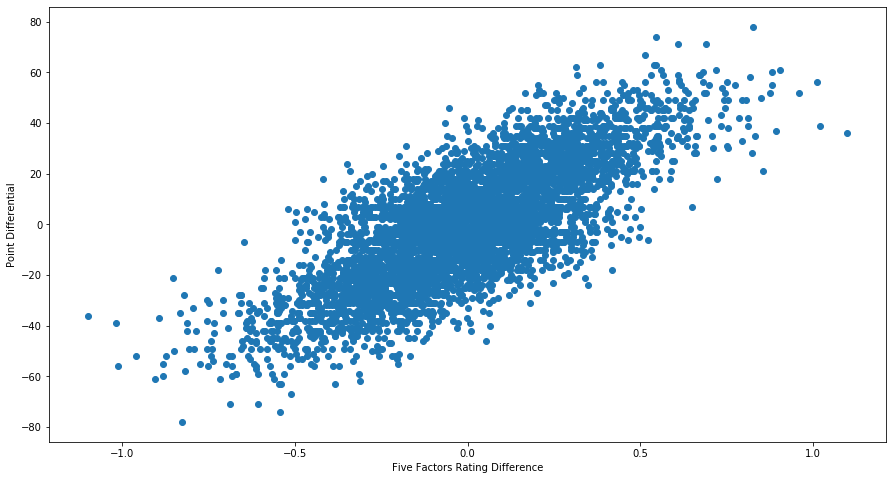

In [173]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [174]:
# Eliminate outliers
# basis = stored_game_boxes[stored_game_boxes['5FRDiff'] != 0]
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [175]:
outliers

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Charlotte,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.000000,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484,3.850888,2.532445
1,Louisville,70.0,56.0,0.999941,0.681159,0.289855,9.275362,33.866667,4.666667,0.909091,0.733333,0.779661,1.20,0.22,1.351904,1.012484,3.850888,2.532445
0,Hawai'i,3.0,-60.0,0.000004,0.310345,0.103448,4.241379,27.000000,0.272727,0.250000,0.363636,0.486486,1.42,0.22,0.371772,-0.881703,3.353475,2.713334
1,Michigan,63.0,60.0,0.999996,0.694915,0.237288,8.694915,27.000000,7.000000,1.000000,0.777778,0.709091,1.20,-0.22,1.253475,0.881703,3.353475,2.713334
0,Bowling Green,10.0,-67.0,0.000005,0.319444,0.041667,3.388889,22.642857,0.714286,0.500000,0.285714,0.410256,0.66,0.44,0.340262,-0.512154,1.947930,3.029890
1,Ohio State,77.0,67.0,0.999995,0.641304,0.097826,8.282609,31.615385,5.923077,0.909091,0.846154,0.658824,0.22,-0.44,0.852416,0.512154,1.947930,3.029890
0,Bowling Green,3.0,-74.0,0.000002,0.297297,0.054054,3.878378,22.647059,0.176471,0.250000,0.235294,0.451613,1.32,0.88,0.356310,-0.544709,2.071749,3.346446
1,Memphis,77.0,74.0,0.999998,0.472973,0.202703,8.189189,33.588235,4.529412,1.000000,0.588235,0.625000,0.44,-0.88,0.901019,0.544709,2.071749,3.346446
0,Rutgers,0.0,-58.0,0.000006,0.240741,0.037037,2.222222,19.250000,0.000000,0.000000,0.000000,0.000000,0.49,-0.22,0.140585,-0.817478,3.109202,2.622890
1,Ohio State,58.0,58.0,0.999994,0.617978,0.146067,7.516854,35.181818,5.272727,0.900000,0.909091,0.621951,0.71,0.22,0.958063,0.817478,3.109202,2.622890


In [176]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.0,0.416667,0.604651,1.69,0.22,0.706398,-0.106235,0.404057,0.904445
1,California,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.9,0.769231,0.573333,1.47,-0.22,0.812634,0.106235,0.404057,0.904445
1,Wake Forest,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.5,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127,0.289543,0.180889
0,Appalachian State,13.0,-7.0,0.834594,0.459016,0.049180,4.508197,26.500000,1.083333,0.4,0.416667,0.600000,1.91,-0.88,0.311751,-0.183410,0.697583,0.316556
1,Tennessee,20.0,7.0,0.165406,0.361111,0.027778,4.388889,32.818182,1.818182,0.8,0.454545,0.418605,2.79,0.88,0.495161,0.183410,0.697583,0.316556


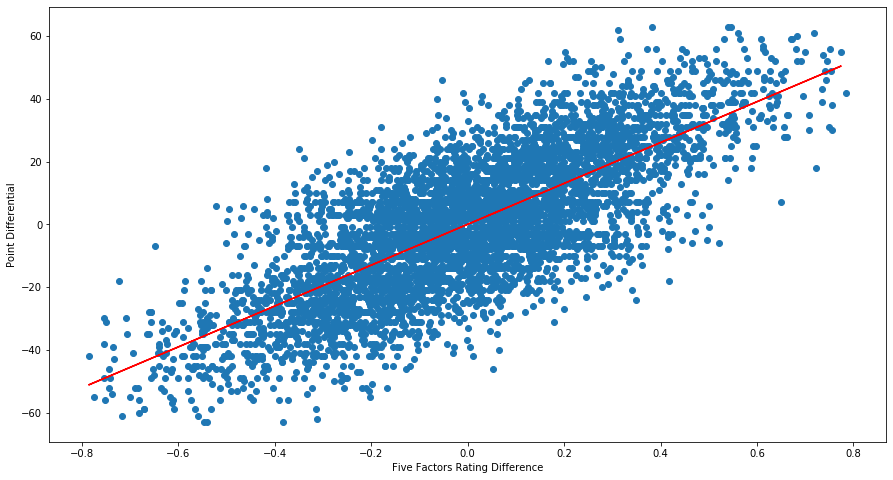

In [177]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [178]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

test = pd.DataFrame({
    'ActPtsDiff':test_data['PtsDiff'],
    'PredPtsDiff' : yfit
})

test.corr()

Linear Regression: y = 65.11200x + 0.02479


,ActPtsDiff,PredPtsDiff
ActPtsDiff,1.000000,0.752675
PredPtsDiff,0.752675,1.000000


In [179]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [180]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
5FRDiff for Virginia Tech: 0.052567774458461725

Proj MOV by 5FRDiff: Virginia Tech by 3.0 (exact value: 3.4475856902852517)
Z score: 0.18553629791612816
Win Prob for Virginia Tech: 57.36%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [181]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
5FRDiff for Georgia Tech: -0.1184291142016603

Proj MOV by 5FRDiff: Georgia Tech by -8.0 (exact value: -7.686364498570899)
Z score: -0.4771451828801317
Win Prob for Georgia Tech: 31.66%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,3.111111,0.500000,0.444444,0.47619,0.93,-0.66,0.481263,-0.118429
1,Miami,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,1.750000,0.333333,0.750000,0.40000,1.59,0.66,0.599692,0.118429


In [182]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
5FRDiff for Georgia Tech: 0.030736975176983372

Proj MOV by 5FRDiff: Georgia Tech by 2.0 (exact value: 2.0261385886013423)
Z score: 0.10093320070088745
Win Prob for Georgia Tech: 54.02%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,NC State,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,2.600000,0.833333,0.600000,0.552239,0.98,0.0,0.655222,-0.030737
1,Georgia Tech,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,2.545455,0.571429,0.636364,0.571429,0.98,0.0,0.685959,0.030737


In [183]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
5FRDiff for Mississippi State: 0.048901702816578796

Proj MOV by 5FRDiff: Mississippi State by 3.0 (exact value: 3.208880416935903)
Z score: 0.17132880090618566
Win Prob for Mississippi State: 56.80%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Ole Miss,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,1.818182,0.60,0.454545,0.473684,1.20,0.22,0.508653,-0.048902
1,Mississippi State,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,1.750000,0.75,0.333333,0.533333,0.98,-0.22,0.557555,0.048902


In [184]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
5FRDiff for Texas A&M: -0.035671978147348016

Proj MOV by 5FRDiff: Texas A&M by -2.0 (exact value: -2.2978814810083334)
Z score: -0.1564281107939028
Win Prob for Texas A&M: 43.78%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,LSU,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,0.49,0.0,0.707957,0.035672
1,Texas A&M,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,0.49,0.0,0.672285,-0.035672


In [227]:
# Team Ratings by Avg Win Prob??

def calculate_avg_win_prob(team, year):
    tester = stored_game_boxes[stored_game_boxes.Team == team]['5FRDiff'].mean()
    pred = model.predict([[tester]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

,team,avg_win_prob,proj_wins,proj_losses
0,Alabama,0.902882,11.0,1.0
0,Oklahoma,0.890141,11.0,1.0
0,Clemson,0.861668,10.0,2.0
0,Ohio State,0.844788,10.0,2.0
0,Georgia,0.782284,9.0,3.0
0,Michigan,0.781991,9.0,3.0
0,Memphis,0.778985,9.0,3.0
0,Penn State,0.775976,9.0,3.0
0,Washington,0.768482,9.0,3.0
0,Notre Dame,0.744051,9.0,3.0


In [256]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(f"rating diff is {ffr_diff}")
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
#     print(f"{team1} should beat {team2} by {pred[0]} and should win {(100 * win_prob):.2f}% of the time")
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.2617462587437947, -10.388458010225998]

In [257]:
team_triples = [
    ['Texas','Texas Tech',9.5],
    ['Virginia Tech','Virginia',2.5],
    ['Iowa','Nebraska',5.5],
    ['Missouri','Arkansas',11.5],
    ['Memphis','Cincinnati',11.5],
    ['Washington','Washington State',7.5],
    ['Georgia','Georgia Tech',28.5],
    ['Kentucky','Louisville',2.5],
    ['Clemson', 'South Carolina',27.5],
    ['Ohio State','Michigan',8.5],
    ['Indiana','Purdue',7.5],
    ['Miami','Duke',7.5],
    ['Wisconsin','Minnesota',2.5],
    ['Alabama','Auburn',3.5],
    ['Tennessee','Vanderbilt',22.5],
    ['Oregon','Oregon State',19.5],
    ['Notre Dame','Stanford',16.5],
    ['North Carolina','NC State',7.5],
    ['LSU','Texas A&M',16.5],
    ['Florida','Florida State',17.5],
    ['Utah','Colorado',17.5],
    ['Oklahoma','Oklahoma State',13.5],
    ['Arizona State','Arizona',13.5],
    ['Hawai\'i','Army',3.5]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_win_prob'], ascending=False)

,team,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ats_pick
0,Memphis,Cincinnati,11.5,15.220508,0.812258,True,Memphis
0,Oklahoma,Oklahoma State,13.5,14.333230,0.797701,True,Oklahoma
0,Alabama,Auburn,3.5,13.271380,0.779421,True,Alabama
0,Clemson,South Carolina,27.5,11.811069,0.752798,False,South Carolina
0,Hawai'i,Army,3.5,8.311716,0.682622,True,Hawai'i
0,Georgia,Georgia Tech,28.5,7.959627,0.675117,False,Georgia Tech
0,Ohio State,Michigan,8.5,5.485496,0.620514,False,Michigan
0,Utah,Colorado,17.5,4.739705,0.603510,False,Colorado
0,Miami,Duke,7.5,4.486265,0.597684,False,Duke
0,Oregon,Oregon State,19.5,3.314373,0.570484,False,Oregon State
